In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
from xgcm import Grid
from os.path import join,expanduser
import ecco_v4_py as ecco
import seaborn as sns
import tensorflow as tf
import scipy.io
import time
import warnings
import matplotlib.colors as colors
import dask
import statsmodels.api as sm
from pyDOE import *
import matplotlib.animation as animation
from IPython.display import HTML

np.random.seed(4321)
tf.set_random_seed(4321)
print('all done')
%matplotlib inline

/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages

all done


In [2]:
# LOADING IN ECCO GRID + DATA

grid_path = '/projects/SOCCOM/datasets/ecco/Version4/Release4/nctiles_grid/'
ecco_grid = xr.open_dataset(grid_path+'ECCO-GRID.nc')

ds = xr.Dataset()
tags = ['THETA','SALT','EVEL', 'NVEL', 'WVELMASS', 'PHIHYD', 'RHOAnoma']

for i in range(1992,1993):
    for tag in tags:
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            data_path = '/projects/SOCCOM/datasets/ecco/Version4/Release4/interp_monthly/'+tag+'/' + str(i) +'/'+tag+'_' + str(i) + '_??.nc'
            dsnow = xr.open_mfdataset(data_path,chunks="auto",data_vars='minimal',coords='minimal', compat='override') 
            ds = xr.merge([ds, dsnow])
    print('the year ' + str(i) + ' is loaded')
    
# make the XGCM object
xgcm_grid = ecco.get_llc_grid(ecco_grid)

# interpolate w velocity onto regular grid
WVELMASS_interp = xgcm_grid.interp(ds.WVELMASS, "Z", boundary='fill')
# adjusting the pressure anomaly to not be 1/rho
PHI = ds.PHIHYD*(ds.RHOAnoma+1029) # rho_const = 1029
# creating land mask
maskC = ds.SALT.where(np.logical_or(ds.SALT.isnull(), ds.SALT==0),1).isel(time=0)

# get the grid
ds = xr.merge([ds, WVELMASS_interp.rename('WVELMASS_interp'), PHI.rename('PHI'), maskC.rename('maskC')],compat='override')

ds

the year 1992 is loaded


<xarray.Dataset>
Dimensions:          (i: 720, k: 50, j: 360, time: 12, nv: 2, k_l: 50)
Coordinates:
  * i                (i) int64 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
  * k                (k) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * j                (j) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * time             (time) datetime64[ns] 1992-01-16T12:00:00 ... 1992-12-16...
    latitude         (j) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    longitude        (i) float64 dask.array<chunksize=(720,), meta=np.ndarray>
    Z                (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    timestep         (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds        (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
  * k_l              (k_l) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
    Zl               (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    THETA            (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    SALT             (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    EVEL             (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    NVEL             (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    WVELMASS         (time, k_l, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    PHIHYD           (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    RHOAnoma         (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    WVELMASS_interp  (time, k, j, i) float64 dask.array<chunksize=(1, 49, 360, 720), meta=np.ndarray>
    PHI              (time, k, j, i) float64 dask.array<chunksize=(1, 50, 360, 720), meta=np.ndarray>
    maskC            (k, j, i) float64 dask.array<chunksize=(50, 360, 720), meta=np.ndarray>

In [5]:
test = using_multiindex(ds.THETA.isel(k=slice(0,5),j=slice(0,5),i=slice(35,40)).squeeze().values, ['time', 'k', 'j', 'i'])
test = test.to_numpy()
coords_nn = test[:,0:4].astype(int)
coords_nn

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  1],
       [ 0,  0,  0,  2],
       ...,
       [11,  4,  4,  2],
       [11,  4,  4,  3],
       [11,  4,  4,  4]])

In [28]:
# ds.THETA.isel(time=0,k=0).plot(x='longitude',y='latitude',cmap='RdYlBu_r')
# plt.show()
# ds.THETA.isel(time=0,k=0,i=slice(30,35),j=slice(30,35)).plot(x='longitude',y='latitude',cmap='RdYlBu_r')
# plt.show()
# train_idx = range(len(coords_nn[:,0]))
# a=6371*1000
# throwaway = (np.radians(ds.longitude[35:40])*a*np.cos(np.radians(ds.latitude[0:5]))) # Y positions lat*r
# throwaway2 = np.zeros_like(coords_nn[:,2])
# # throwaway = np.radians(ds.longitude.isel(i=slice(*i_ind)))*a*np.cos(np.radians(ds.latitude.isel(j=slice(*j_ind)))) # these are the X positions lon*rcos(lat)
# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#     for i in range(len(coords_nn[:,2])):
#         throwaway2[i] = throwaway[coords_nn[i,2],coords_nn[i,3]]#.values#[0,:]
# throwaway2
throwaway2.shape
# throwaway[coords_nn[:,2]][coords_nn[:,3]].shape
# throwaway = np.cos(np.radians(ds.latitude[0:5])).values
# throwaway
# coords_nn[:,2].shape
# throwaway = np.radians(ds.latitude)*a*np.cos(0*np.radians(ds.longitude)) # Y positions lat*r
# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#     throwaway = throwaway[coords_nn[:,3],coords_nn[:,2]].values[:,2]
# throwaway
# test.plot(x='longitude',y='latitude')
# test = test.transpose()

(1500,)

In [14]:
Omega = (2*np.pi)/86164
f = 2*Omega*np.sin((np.pi/180)*ds.latitude)

# calculate pressure gradients
DPDX = (xgcm_grid.diff(ds.PHIHYDcR.where(ds.maskC),axis="X",boundary='extend'))/ds.dxC # 1/rho p_x
DPDY = (xgcm_grid.diff(ds.PHIHYDcR.where(ds.maskC),axis="Y",boundary='extend'))/ds.dyC # 1/rho p_y
press_grads_interp = xgcm_grid.interp_2d_vector({"X":DPDX,"Y":DPDY},boundary='extend')
DPDX = press_grads_interp['X']/f
DPDY = -press_grads_interp['Y']/f
ds = xr.merge([ds, DPDX.rename('VGEO'), DPDY.rename('UGEO')])

TypeError: an integer is required (got type str)

In [89]:
# calculate pressure gradients (using PHIHYD instead of PHIHYDcR)

ds = ds.drop_vars(["UGEO", "VGEO","UGEO2","VGEO2"])
DPDX = (xgcm_grid.diff(ds.PHIHYDcR.where(ds.maskC),axis="X",boundary='extend'))/ds.dxC # 1/rho p_x
DPDY = (xgcm_grid.diff(ds.PHIHYDcR.where(ds.maskC),axis="Y",boundary='extend'))/ds.dyC # 1/rho p_y
press_grads_interp = xgcm_grid.interp_2d_vector({"X":DPDX,"Y":DPDY},boundary='extend')
DPDX = press_grads_interp['X']/f
DPDY = press_grads_interp['Y']/f
ds = xr.merge([ds, DPDX.rename('UGEO'), DPDY.rename('VGEO')],compat='override')

In [18]:
# # # training dataset
# tile_ind = (3,4)
# k_ind = (20,22)
# j_ind = (70,90)
# i_ind = (70,90)

# # dx = ds.dxC.isel(tile=slice(*tile_ind),j=slice(*j_ind),i_g=slice(*i_ind))
# # dy = ds.dyC.isel(tile=slice(*tile_ind),j_g=slice(*j_ind),i=slice(*i_ind))

dx = ds.XC.isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind))*111.32*1000
dy = ds.YC.isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind))*111.32*1000

# assuming latitude lines are 111.32 km wide and f is constant (f-plane)

# # rescaling to m instead of deg
# # dx = dx*111.32*1000
# # dy = dy*111.32*1000

# # shift to become centered 
dx = dx-((dx.max() -dx.min())/2+dx.min())
dy = dy-((dy.max() -dy.min())/2+dy.min())

# dx.max

# ds_new = ds.where(ds.maskC).isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind),k=slice(*k_ind))
ds_new = ds_new.assign_coords({"x_m": dx})
ds_new = ds_new.assign_coords({"y_m": dy})
# ds_new
ds_new.EVEL.isel(time=0,k=0).plot(x='x_m',y='y_m',cmap='RdYlBu_r')
# plt.show()


AttributeError: 'Dataset' object has no attribute 'XC'

In [3]:
# DATA PREPROCESSING (with Navier Stokes normalization)

# gets the index of the array for each dimension before flattening
def using_multiindex(A, columns):
    shape = A.shape
    index = pd.MultiIndex.from_product([range(s) for s in shape], names=columns)
    df = pd.DataFrame({'A': A.flatten()}, index=index).reset_index()
    return df

def make_nninputs(ds, tags, time_ind, depth_ind, j_ind, i_ind, N_train):
    # ds is the main ecco data array
    # tags is a list of strings corresponding to the input variables i.e. ['THETA','SALT', ...]
        # first tagged variable must be in 4d, others can be in 3d
    # tile_ind, depth_ind, j_ind, and i_ind are tuples for subsetted data
    # N_train is a number between 0 and 100 describing percentage of data sampled
    # returns inputs_nn which is an array of all the training data of size N points x [time, depth, lat, lon, tags...]
    # returns coords_nn which is an array of all the training data coordinates of size N points x [time, k, j, i]
    
    subset_template = ds[tags[0]].where(ds.maskC>0).isel(time=slice(*time_ind),k=slice(*depth_ind),j=slice(*j_ind),i=slice(*i_ind))
    # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)
    inputs_nn = using_multiindex(subset_template.squeeze().values, ['time', 'k', 'j', 'i']) # makes array N x 5 [time, k, j, i, *first tag*]
    inputs_nn = inputs_nn.to_numpy()
    if N_train < 100: # for validation data no need to scramble coordinates
        N_train = int(N_train/100*len(inputs_nn[:,0]))
        train_idx = np.random.choice(len(inputs_nn[:,0]), N_train, replace=False) # Generate a random sample from np.arange(N*T) of size N_train
    else: 
        train_idx = range(len(inputs_nn[:,0]))
    inputs_nn = inputs_nn[train_idx,:] # subsample the training data
    coords_nn = inputs_nn[:,0:4].astype(int) # makes the time,kji indices integers for future use
    inputs_nn = inputs_nn[:,4:] # trim array by cutting out coordinates
    
    for tag in tags:
        throwaway = ds[tag].where(ds.maskC).isel(time=slice(*time_ind),k=slice(*depth_ind),j=slice(*j_ind),i=slice(*i_ind)).squeeze().values.flatten()[train_idx,np.newaxis]
        inputs_nn = np.concatenate((inputs_nn, throwaway),axis=1)

    inputs_nn = inputs_nn[:,1:] # need to remove the first dummy variable
    
    # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)
    
    a=6371*1000 # radius of the earth in meters
    throwaway = np.radians(ds.longitude.isel(i=slice(*i_ind)))*a*np.cos(np.radians(ds.latitude.isel(j=slice(*j_ind))))
    throwaway2 = np.zeros((len(train_idx),1))
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        for i in range(len(train_idx)):
            throwaway2[i] = throwaway[coords_nn[i,2],coords_nn[i,3]]    
    # throwaway = throwaway[coords_nn[:,2],coords_nn[:,3]].values[1,:].reshape(len(train_idx),1)  # these are the X positions lon*rcos(lat)
    inputs_nn = np.concatenate((throwaway2,inputs_nn),axis=1)
    throwaway = np.radians(ds.latitude.isel(j=slice(*j_ind)))*a*np.cos(0*np.radians(ds.longitude.isel(i=slice(*i_ind)))) # these are the Y positions lat*r
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        for i in range(len(train_idx)):
            throwaway2[i] = throwaway[coords_nn[i,2],coords_nn[i,3]]  
    # throwaway = throwaway[coords_nn[:,3],coords_nn[:,2]].values[:,1].reshape(len(train_idx),1)
    inputs_nn = np.concatenate((throwaway2,inputs_nn),axis=1)
    # if tile is flipped (evel not uvel), need values[1,:] for YC and values[:,1] for XC
    throwaway = ds.Z.isel(k=slice(*depth_ind)).values[coords_nn[:,1],np.newaxis] # get depth coordinates
    inputs_nn = np.concatenate((throwaway,inputs_nn),axis=1)
    throwaway = ds.timestep.isel(time=slice(*time_ind)).values[coords_nn[:,0],np.newaxis]*3600
    inputs_nn = np.concatenate((throwaway,inputs_nn),axis=1)

    lb_nn = np.nanmin(inputs_nn,axis=0)
    char_nn = (np.nanmax(inputs_nn,axis=0)-lb_nn)/2
    inputs_nn = (inputs_nn-lb_nn)/char_nn - 1
    
    # get rid of the nans after calculating mean + std
    inputs_nn[np.isnan(inputs_nn)] = 0
                                   
    return subset_template, inputs_nn, coords_nn, char_nn, lb_nn


In [7]:
# N_train=5
# subset_template = ds[tags[0]].where(ds.SALT>0).isel(time=slice(*time_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind))
# # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)
# inputs_nn = using_multiindex(subset_template.squeeze().values, ['time', 'k', 'j', 'i']) # makes array N x 5 [time, k, j, i, *first tag*]
# inputs_nn = inputs_nn.to_numpy()
# if N_train < 100: # for validation data no need to scramble coordinates
#     N_train = int(N_train/100*len(inputs_nn[:,0]))
#     train_idx = np.random.choice(len(inputs_nn[:,0]), N_train, replace=False) # Generate a random sample from np.arange(N*T) of size N_train
# else: 
#     train_idx = range(len(inputs_nn[:,0]))
# inputs_nn = inputs_nn[train_idx,:] # subsample the training data
# coords_nn = inputs_nn[:,0:4].astype(int) # makes the time,kji indices integers for future use
# inputs_nn = inputs_nn[:,4:] # trim array by cutting out coordinates
# coords_nn

# ds.longitude.isel(i=slice(*i_ind))[coords_nn[:,3],np.newaxis]
char_train

array([1.44720000e+07, 6.33950043e+01, 5.28770000e+05, 5.28770000e+05,
       2.75057912e-01, 6.52427673e-02, 1.80361094e-02, 1.07628081e-02,
       5.54553901e-06, 5.60709000e+00])

training dataset is processed!


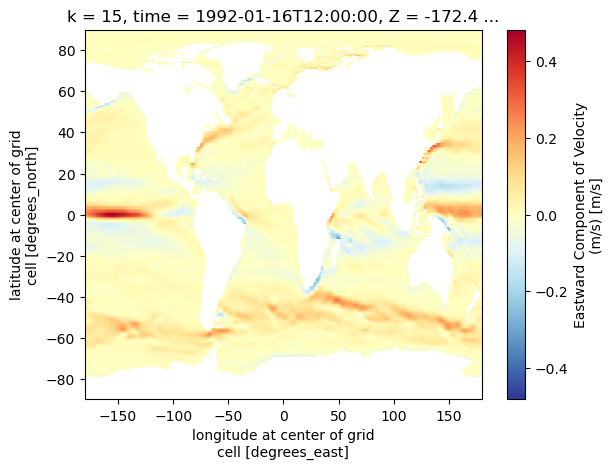

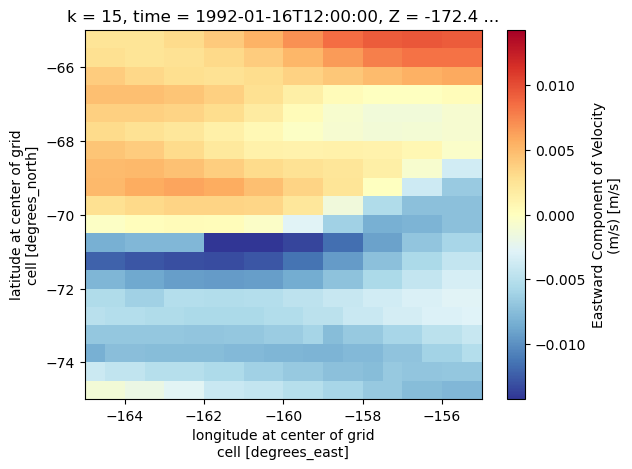

validation dataset is processed!


In [4]:
# MAKE TESTING, VALIDATION, AND TRAINING DATA

tags = ['THETA','SALT','EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma']

# tile_ind = (4,5)
time_ind = (0,12)
k_ind = (15,25)
j_ind = (30,50)
i_ind = (30,50)

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    _, inputs_train, coords_train, char_train, lb_train = make_nninputs(ds,tags, time_ind, k_ind, j_ind, i_ind, 5)
print('training dataset is processed!')

# plot the whole tile + training area
ds.EVEL.where(ds.SALT>0).isel(time=0,k=k_ind[0]).plot(x='longitude',y='latitude',cmap='RdYlBu_r')
plt.show()
ds.EVEL.where(ds.SALT>0).isel(j=slice(*j_ind),i=slice(*i_ind),time=0,k=k_ind[0]).plot(x='longitude',y='latitude',cmap='RdYlBu_r')
plt.show()

# validation dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    subset_template, inputs_val, coords_val, char_val, lb_val = make_nninputs(ds,tags, time_ind, k_ind, j_ind, i_ind,100) 
print('validation dataset is processed!')

# # plot the validation area
# ds.EVEL.where(ds.maskC).isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind),time=0,k=k_ind[0]).plot(x='i',y='j',cmap='RdYlBu_r')
# plt.show()

In [8]:
# making the collocation points 

nCol = int(0.5*inputs_val.shape[0])
lb = np.min(inputs_train,0)
lb = lb[0:4]
ub = np.max(inputs_train,0)
ub = ub[0:4]
col_train = lb + (ub-lb)*lhs(4, nCol)

# calculate the coriolis constant for the collocation points
throwaway = (col_train[:,2]+1)*char_train[2] + lb_train[2]
f_col = 2*(2*np.pi)/86164*np.sin(throwaway*np.pi/180)
f_col = f_col.reshape((f_col.shape[0],1)).astype('float32')

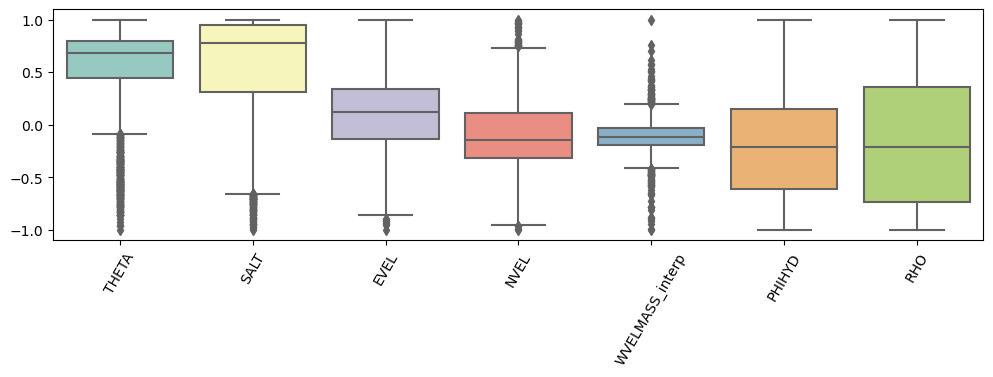

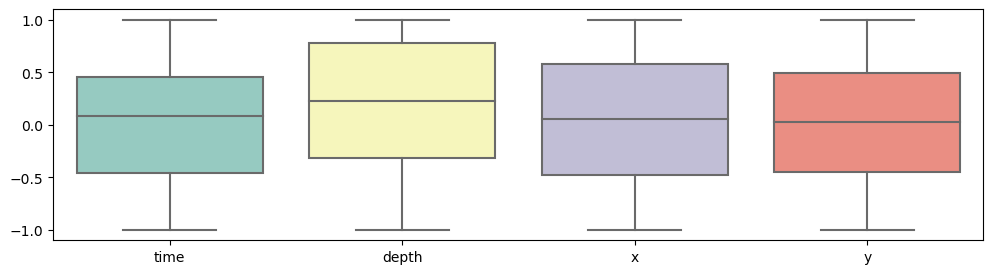

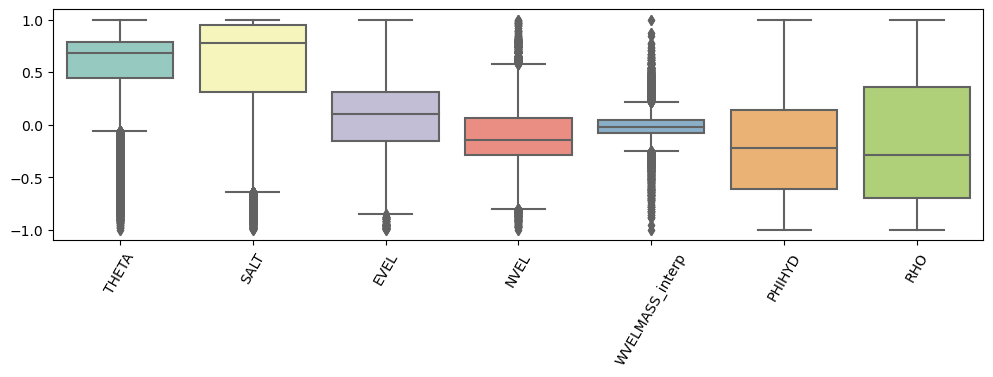

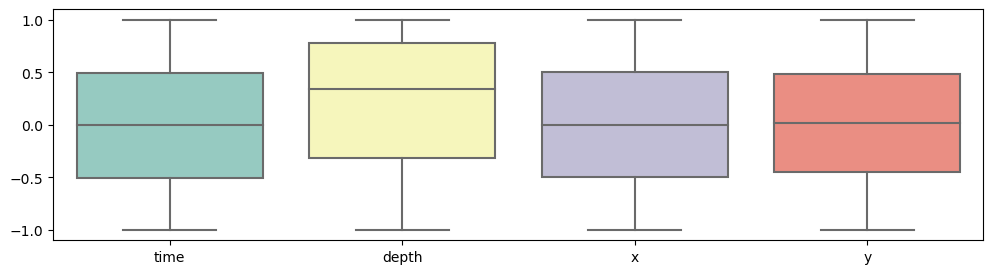

In [5]:
# # plot the normalized version of the training data

tags = ['THETA','SALT', 'EVEL', 'NVEL','WVELMASS_interp','PHIHYD','RHO']

fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_train[:,4:12], palette="Set3")
_ = ax.set_xticklabels(tags, rotation=60)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_train[:,0:4], palette="Set3")
_ = ax.set_xticklabels(['time','depth','x','y'], rotation=0)
plt.show()

# plot the normalized version of the validation data as well to make sure distributions match

fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_val[:,4:12], palette="Set3")
_ = ax.set_xticklabels(tags, rotation=60)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_val[:,0:4], palette="Set3")
_ = ax.set_xticklabels(['time','depth','x','y'], rotation=0)
plt.show()

In [32]:
# class PhysicsInformedNN:
#     # Initialize the class
    
#     def __init__(self, inputs_nn, char_nn, lb_nn, col_nn, layers):
        
#         # Training points
        
#         X = inputs_nn[:,0:8]
                
#         self.X = X
        
#         self.char_nn = char_nn
#         self.lb_nn = lb_nn

#         self.t = inputs_nn[:,0:1]
#         self.k = inputs_nn[:,1:2]
#         self.j = inputs_nn[:,2:3]
#         self.i = inputs_nn[:,3:4]
    
#         self.T = inputs_nn[:,4:5]
#         self.S = inputs_nn[:,5:6]
# #         self.obp = inputs_nn[:,6:7]
# #         self.ssh = inputs_nn[:,7:8]
        
#         self.u = inputs_nn[:,8:9]
#         self.v = inputs_nn[:,9:10]
#         self.w = inputs_nn[:,10:11]
#         self.p = inputs_nn[:,11:12]
        
#         # Collocation points
        
#         self.t_c = col_nn[:,0:1]
#         self.k_c = col_nn[:,1:2]
#         self.j_c = col_nn[:,2:3]
#         self.i_c = col_nn[:,3:4]

#         self.T_c = col_nn[:,4:5]
#         self.S_c = col_nn[:,5:6]
# #         self.obp_c = col_nn[:,6:7]
# #         self.ssh_c = col_nn[:,7:8]
        
#         self.layers = layers
        
#         # Initialize NN
#         self.weights, self.biases = self.initialize_NN(layers)        
        
#         # tf placeholders and graph
#         self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
#                                                      log_device_placement=True))
        
#         # training point tf placeholders
#         self.i_tf = tf.placeholder(tf.float32, shape=[None, self.i.shape[1]])
#         self.j_tf = tf.placeholder(tf.float32, shape=[None, self.j.shape[1]])
#         self.k_tf = tf.placeholder(tf.float32, shape=[None, self.k.shape[1]])
#         self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
#         self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
#         self.T_tf = tf.placeholder(tf.float32, shape=[None, self.T.shape[1]])
# #         self.ssh_tf = tf.placeholder(tf.float32, shape=[None, self.ssh.shape[1]])
# #         self.obp_tf = tf.placeholder(tf.float32, shape=[None, self.obp.shape[1]])
        
#         self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
#         self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]]) 
#         self.w_tf = tf.placeholder(tf.float32, shape=[None, self.w.shape[1]])
#         self.p_tf = tf.placeholder(tf.float32, shape=[None, self.p.shape[1]])
        
#         # collocation point tf placeholders
#         self.i_ctf = tf.placeholder(tf.float32, shape=[None, self.i_c.shape[1]])
#         self.j_ctf = tf.placeholder(tf.float32, shape=[None, self.j_c.shape[1]])
#         self.k_ctf = tf.placeholder(tf.float32, shape=[None, self.k_c.shape[1]])
#         self.t_ctf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])
        
#         self.S_ctf = tf.placeholder(tf.float32, shape=[None, self.S_c.shape[1]])
#         self.T_ctf = tf.placeholder(tf.float32, shape=[None, self.T_c.shape[1]])
# #         self.ssh_ctf = tf.placeholder(tf.float32, shape=[None, self.ssh_c.shape[1]])
# #         self.obp_ctf = tf.placeholder(tf.float32, shape=[None, self.obp_c.shape[1]])

#         # equation loss tf placeholders
# #         self.fu_pred_losses = tf.placeholder(tf.float32, shape=[250, self.T_c.shape[1]])
        
#         # observation points
#         self.u_pred, self.v_pred, self.w_pred, self.p_pred = self.net_NS(self.t_tf, self.k_tf, self.j_tf, self.i_tf, self.T_tf, self.S_tf)
        
#         # collocation points
#         self.fcont, self.fv_pred, self.fu_pred = self.net_f_NS(self.t_ctf, self.k_ctf, self.j_ctf, self.i_ctf, self.T_ctf, self.S_ctf)
# #         self.fu_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x = self.net_f_NS(self.t_ctf, self.k_ctf, self.j_ctf, self.i_ctf, self.T_ctf, self.S_ctf)
        
#         # losses
#         self.eqloss = tf.reduce_mean(tf.square(self.fcont)) + \
#                     tf.reduce_mean(tf.square(self.fv_pred)) + \
#                     tf.reduce_mean(tf.square(self.fu_pred))

# #         self.eqloss = tf.reduce_mean(tf.abs(self.fu_pred))
        
#         self.dataloss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
#                     tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + \
#                     tf.reduce_mean(tf.square(self.w_tf - self.w_pred)) + \
#                     tf.reduce_mean(tf.square(self.p_tf - self.p_pred))

# #         self.dataloss = tf.reduce_mean(tf.abs(self.u_tf - self.u_pred)) + \
# #                     tf.reduce_mean(tf.abs(self.v_tf - self.v_pred)) + \
# #                     tf.reduce_mean(tf.abs(self.w_tf - self.w_pred)) + \
# #                     tf.reduce_mean(tf.abs(self.p_tf - self.p_pred))
        
#         self.loss = self.dataloss + 0*self.eqloss
    
#         # saved losses
        
#         self.losses = []
#         self.eq_losses = []
#         self.data_losses = []
#         self.fu_pred_losses = []
#         self.u_t_losses = []
#         self.uu_x_losses = []
#         self.vu_y_losses = []
#         self.wu_z_losses = []
#         self.fv_losses = []
#         self.p_x_losses = [] 
        
#         self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
#                                                                 method = 'L-BFGS-B', 
#                                                                 options = {'maxiter': 2000,  # original maxiter is 50000
#                                                                            'maxfun': 50000,
#                                                                            'maxcor': 50,
#                                                                            'maxls': 50,
#                                                                            'ftol' : 1.0 * np.finfo(float).eps})        
        
#         self.optimizer_Adam = tf.train.AdamOptimizer()
#         self.train_op_Adam = self.optimizer_Adam.minimize(self.loss) 
        
#         init = tf.global_variables_initializer()
#         self.saver = tf.train.Saver()
#         self.sess.run(init)

#     def initialize_NN(self, layers): 
#         weights = []
#         biases = []
#         num_layers = len(layers) 
#         for l in range(0,num_layers-1):
#             W = self.xavier_init(size=[layers[l], layers[l+1]])
#             b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
#             weights.append(W)
#             biases.append(b)        
#         return weights, biases
        
#     def xavier_init(self, size):
#         in_dim = size[0]
#         out_dim = size[1]        
#         xavier_stddev = np.sqrt(2/(in_dim + out_dim))
# #         initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in')
#         return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
# #         return tf.Variable(initializer(shape=(in_dim, out_dim)), dtype=tf.float32)
    
#     def neural_net(self, X, weights, biases):
#         num_layers = len(weights) + 1
#         H = X
#         for l in range(0,num_layers-2):
#             W = weights[l]
#             b = biases[l]
# #             H = tf.keras.activations.selu(tf.add(tf.matmul(H, W), b))
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
#         W = weights[-1]
#         b = biases[-1]
#         Y = tf.add(tf.matmul(H, W), b) # linear activation function for the last layer
#         return Y
        
#     def net_f_NS(self, t, k, j, i, T, S):
#         # getting equation losses on collocation points
#         with tf.GradientTape(persistent=True) as tape:
#             # Watch the input variables
#             tape.watch(t)
#             tape.watch(k)
#             tape.watch(j)
#             tape.watch(i)

#             uvwp = self.neural_net(tf.concat([t, k, j, i, T, S], 1), self.weights, self.biases)
#             u_hat = uvwp[:,0:1]
#             v_hat = uvwp[:,1:2]
#             w_hat = uvwp[:,2:3]
#             p_hat = uvwp[:,3:4]
        
#         char_nn = self.char_nn
#         lb_nn = self.lb_nn
        
# #         phi = ((j+1)*char_nn[2] + lb_nn[2])/111
# #         f = 2*(2*np.pi)/86164*tf.math.sin(phi*np.pi/180)
# #         f = -0.00012848
# #         f = -1.7199432e-05
#         f = -0.0001370470931755048
        
#         u_t, u_z, u_y, u_x = tape.gradient(u_hat, [t, k, j, i])
#         v_t, v_z, v_y, v_x = tape.gradient(v_hat, [t, k, j, i])
#         w_z = tape.gradient(w_hat, k)
#         p_y, p_x = tape.gradient(p_hat, [j, i])

# #         fcont = u_x + char_nn[9]*char_nn[3]/char_nn[2]/char_nn[8]*v_y + char_nn[3]*char_nn[10]/char_nn[1]/char_nn[8]*w_z
# #         fcont = char_nn[8]/char_nn[3]*u_x + char_nn[9]/char_nn[2]*v_y + char_nn[10]/char_nn[1]*w_z
        
#         fu = char_nn[3]/char_nn[0]/char_nn[8]*u_t + u_hat*u_x + char_nn[9]*char_nn[3]/char_nn[8]/char_nn[2]*v_hat*u_y + char_nn[10]*char_nn[3]/char_nn[1]/char_nn[8]*w_hat*u_z - f*char_nn[3]*char_nn[9]/char_nn[8]**2*v_hat + char_nn[11]/char_nn[8]**2*p_x
# #         fu = char_nn[8]/char_nn[0]*u_t + char_nn[8]**2/char_nn[3]*u_hat*u_x + char_nn[8]*char_nn[9]/char_nn[2]*v_hat*u_y + char_nn[8]*char_nn[10]/char_nn[1]*w_hat*u_z - char_nn[9]*f*v_hat + char_nn[11]/char_nn[3]*p_x
        
# #         fv = char_nn[2]/char_nn[0]/char_nn[9]*v_t + char_nn[8]*char_nn[2]/char_nn[3]/char_nn[9]*u_hat*v_x + v_hat*v_y + char_nn[10]*char_nn[2]/char_nn[1]/char_nn[9]*w_hat*v_z + f*char_nn[8]*char_nn[2]/char_nn[9]**2*u_hat + char_nn[11]/char_nn[9]**2*p_y
# #         fv = char_nn[9]/char_nn[0]*v_t + char_nn[8]*char_nn[9]/char_nn[3]*u_hat*v_x + char_nn[9]**2/char_nn[2]*v_hat*v_y + char_nn[9]*char_nn[10]/char_nn[1]*w_hat*v_z + char_nn[8]*f*u_hat + char_nn[11]/char_nn[2]*p_y
        
#         fcont = 0*fu
#         fv = 0*fu
    
#         del tape
        
#         return fcont, fv, fu
# #         return xx fu, char_nn[3]/char_nn[0]/char_nn[8]*u_t, u_hat*u_x, char_nn[9]*char_nn[3]/char_nn[8]/char_nn[2]*v_hat*u_y, char_nn[10]*char_nn[3]/char_nn[1]/char_nn[8]*w_hat*u_z, -f*char_nn[3]*char_nn[9]/char_nn[8]**2*v_hat, char_nn[11]/char_nn[8]**2*p_x
    
#     def net_NS(self, t, k, j, i, T, S):
        
#         # getting data loss on observation points
        
#         uvwp = self.neural_net(tf.concat([t, k, j, i, T, S], 1), self.weights, self.biases)
#         u_hat = uvwp[:,0:1]
#         v_hat = uvwp[:,1:2]
#         w_hat = uvwp[:,2:3]
#         p_hat = uvwp[:,3:4]
        
#         return u_hat, v_hat, w_hat, p_hat

# #     def callback(self, loss, dataloss, eqloss, fu_pred, u_t, uu_x, vu_y, wu_z, fv, p_x):
#     def callback(self, loss, dataloss, eqloss, fu_pred):
#         callback_val = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto',baseline=None)
#         print('L-BFGS-B Loss: %.3e, Data loss: %.3e, Equation loss: %.3e' % (loss, dataloss, eqloss))
#         self.losses.append(loss)
#         self.eq_losses.append(eqloss)
#         self.data_losses.append(dataloss)
#         self.fu_pred_losses.append(fu_pred)
# #         self.u_t_losses.append(u_t)
# #         self.uu_x_losses.append(uu_x)
# #         self.vu_y_losses.append(vu_y)
# #         self.wu_z_losses.append(wu_z)
# #         self.fv_losses.append(fv)
# #         self.p_x_losses.append(p_x)
#         return callback_val
 
#     def train(self, nIter): 

#         tf_dict = {self.i_tf: self.i, self.j_tf: self.j, self.k_tf: self.k, self.t_tf: self.t, self.S_tf: self.S, self.T_tf: self.T, self.u_tf: self.u, self.v_tf: self.v, self.w_tf: self.w, self.p_tf: self.p,\
#                    self.i_ctf: self.i_c, self.j_ctf: self.j_c, self.k_ctf: self.k_c, self.t_ctf: self.t_c, self.S_ctf: self.S_c, self.T_ctf: self.T_c}
        
#         start_time = time.time()
# #         losses = np.zeros(nIter//10)
# #         eq_losses = np.zeros(nIter//10)
# #         data_losses = np.zeros(nIter//10)
#         for it in range(nIter):
#             self.sess.run(self.train_op_Adam, tf_dict)
#             loss_value = self.sess.run(self.loss, tf_dict)
#             data_value = self.sess.run(self.dataloss, tf_dict)
#             eq_value = self.sess.run(self.eqloss, tf_dict)
#             fu_value = self.sess.run(self.fu_pred,tf_dict)
# #             u_t_value = self.sess.run(self.u_t,tf_dict)
# #             uu_x_value = self.sess.run(self.uu_x,tf_dict)
# #             vu_y_value = self.sess.run(self.vu_y,tf_dict)
# #             wu_z_value = self.sess.run(self.wu_z,tf_dict)
# #             fv_value = self.sess.run(self.fv,tf_dict)
# #             p_x_value = self.sess.run(self.p_x,tf_dict)
            
#             self.losses.append(loss_value)
#             self.eq_losses.append(eq_value)
#             self.data_losses.append(data_value)
#             self.fu_pred_losses.append(fu_value)
# #             self.u_t_losses.append(u_t_value)
# #             self.uu_x_losses.append(uu_x_value)
# #             self.vu_y_losses.append(vu_y_value)
# #             self.wu_z_losses.append(wu_z_value)
# #             self.fv_losses.append(fv_value)
# #             self.p_x_losses.append(p_x_value) 
            
#             # Print
#             if it % 10 == 0:
#                 elapsed = time.time() - start_time
#                 print('Adam It: %d, Total loss: %.3e, Data loss: %.3e, Equation loss: %.3e, Time: %.2f' % 
#                       (it, loss_value, data_value, eq_value, elapsed))
                
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.dataloss, self.eqloss, self.fu_pred],
# #                                 fetches = [self.loss, self.dataloss, self.eqloss, self.fu_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x],
# #                                 loss_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='auto',verbose=2,baseline=None))
#                                 loss_callback = self.callback)
        
#         # for plotting the equation residue
# #         self.eq_res = self.fcont + self.fv_pred + self.fu_pred
# #         eq_res = self.sess.run(self.fu_pred, tf_dict)
        
#         return self.losses, self.eq_losses, self.data_losses, self.fu_pred_losses
# #         return self.losses, self.eq_losses, self.data_losses, self.fu_pred_losses, self.u_t_losses, self.uu_x_losses, self.vu_y_losses, self.wu_z_losses, self.fv_losses, self.p_x_losses
    
#     def predict(self, t_star, k_star, j_star, i_star, T_star, S_star):
        
#         tf_dict = {self.i_tf: i_star, self.j_tf: j_star, self.k_tf: k_star, self.t_tf: t_star, self.T_tf: T_star, self.S_tf: S_star}
        
#         u_star = self.sess.run(self.u_pred, tf_dict)
#         v_star = self.sess.run(self.v_pred, tf_dict)
#         w_star = self.sess.run(self.w_pred, tf_dict)
#         p_star = self.sess.run(self.p_pred, tf_dict)
# #         char_nn = self.char_nn
# #         lb_nn = self.lb_nn
# #         u = (u_star+1)/2*char_nn[8] + lb_nn[8]
# #         v = (v_star+1)/2*char_nn[9] + lb_nn[9]
# #         w = (w_star+1)/2*char_nn[10] + lb_nn[10]
# #         p = (p_star+1)/2*char_nn[11] + lb_nn[11]
        
#         return u_star, v_star, w_star, p_star
# #         return u, v, w, p

#     def compute_gradients(self, t, k, j, i, T, S):
#         tf_dict = {self.i_tf: i, self.j_tf: j, self.k_tf: k, self.t_tf: t, self.S_tf: S, self.T_tf: T}
#             # Compute the outputs
#         with tf.GradientTape(persistent=True) as tape:
#             # Watch the input variables
#             tape.watch(self.t_tf)
#             tape.watch(self.k_tf)
#             tape.watch(self.j_tf)
#             tape.watch(self.i_tf)

#             uvwp = self.neural_net(tf.concat([self.t_tf, self.k_tf, self.j_tf, self.i_tf, self.T_tf, self.S_tf], 1), self.weights, self.biases)
#             u_hat = uvwp[:,0:1]
#             v_hat = uvwp[:,1:2]
#             w_hat = uvwp[:,2:3]
#             p_hat = uvwp[:,3:4]
# #             p_hat = (p_hat+1)/2*self.char_nn[11]+self.lb_nn[11]
            
#             # NOTE TO SELF: HERE RESCALE EVERYTHING BACK TO NORMAL WHILE GRADIENT TAPE IS WATCHING
        
#         inputs = [self.t_tf, self.k_tf, self.j_tf, self.i_tf]
# #         outputs = [u_hat, v_hat, w_hat, p_hat]

#         # Compute the gradients 
#         gradients = [self.sess.run(tape.gradient(u_hat, input_var),feed_dict=tf_dict) for input_var in inputs]

#         # Clean up the tape
#         del tape

#         return gradients, self.sess.run(u_hat,feed_dict=tf_dict)
    
#     def save_model(self, save_path):
#         self.saver.save(self.sess, save_path)
#         print('model saved!')

In [9]:
class PhysicsInformedNN:
    # Initialize the class
    
    def __init__(self, inputs_nn, char_nn, lb_nn, col_nn, layers, f_nn, gamma):
        
        # inputs_nn are the normalized training data
        # char_nn are the characteristic scales of the unnormalized training data
        # lb_nn are the minima of the unnormalized training data
        # col_nn are the normalized collocation points
        # layers are the structure of the PINN
        # f_nn is the coriolis constant for the collocation points
        # gamma is a hyperparameter whose value ranges from 0 to 1 to weigh the overall loss: (1-gamma)*data_loss + gamma*eq_loss

        # Coriolis constants
        self.f_nn = f_nn
        
        # equation weighting
        self.gamma = tf.constant(gamma)
        
        X = inputs_nn[:,0:4]
                
        self.X = X
        
        self.char_nn = char_nn
        self.lb_nn = lb_nn
        
        # Training points
        
        self.t = inputs_nn[:,0:1]
        self.k = inputs_nn[:,1:2]
        self.j = inputs_nn[:,2:3]
        self.i = inputs_nn[:,3:4]
    
        self.T = inputs_nn[:,4:5]
        self.S = inputs_nn[:,5:6]
        
        self.u = inputs_nn[:,6:7]
        self.v = inputs_nn[:,7:8]
        self.w = inputs_nn[:,8:9]
        self.p = inputs_nn[:,9:10]
        self.rho = inputs_nn[:,10:11]
        
        # Collocation points
        
        self.t_c = col_nn[:,0:1]
        self.k_c = col_nn[:,1:2]
        self.j_c = col_nn[:,2:3]
        self.i_c = col_nn[:,3:4]
        
        self.layers = layers
        
        # Counter for the reported NS terms
        self.counter = 0
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # training point tf placeholders
        self.i_tf = tf.placeholder(tf.float32, shape=[None, self.i.shape[1]])
        self.j_tf = tf.placeholder(tf.float32, shape=[None, self.j.shape[1]])
        self.k_tf = tf.placeholder(tf.float32, shape=[None, self.k.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.T_tf = tf.placeholder(tf.float32, shape=[None, self.T.shape[1]])

        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]]) 
        self.w_tf = tf.placeholder(tf.float32, shape=[None, self.w.shape[1]])
        self.p_tf = tf.placeholder(tf.float32, shape=[None, self.p.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        
        # collocation point tf placeholders
        self.i_ctf = tf.placeholder(tf.float32, shape=[None, self.i_c.shape[1]])
        self.j_ctf = tf.placeholder(tf.float32, shape=[None, self.j_c.shape[1]])
        self.k_ctf = tf.placeholder(tf.float32, shape=[None, self.k_c.shape[1]])
        self.t_ctf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])
        
        # diffusion placeholders
        # self.Kz = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=10e-5,stddev=10e-6), dtype=tf.float32)
        # self.Ky = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=10,stddev=1), dtype=tf.float32)
        # self.Kx = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=10,stddev=1), dtype=tf.float32)
        self.Kz = tf.Variable([1e-5], dtype=tf.float32)
        self.Ky = tf.Variable([1e3], dtype=tf.float32)
        self.Kx = tf.Variable([1e3], dtype=tf.float32)

        # observation points
        self.u_pred, self.v_pred, self.w_pred, self.p_pred, self.rho_pred, self.T_pred, self.S_pred = self.net_NS(self.t_tf, self.k_tf, self.j_tf, self.i_tf)
        
        # collocation points
        self.fcont, self.fz_pred, self.fv_pred, self.fu_pred, self.fT_pred, self.fS_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x, self.u_predictions = self.net_f_NS(self.t_ctf, self.k_ctf, self.j_ctf, self.i_ctf)
        
        # losses
        
        self.fT_pred = tf.reduce_mean(tf.square(self.fT_pred))
        self.fS_pred = tf.reduce_mean(tf.square(self.fS_pred)) 
        
        self.diffloss = tf.math.maximum(-1*self.Kx,0) + tf.math.maximum(-1*self.Ky,0) + tf.math.maximum(-1*self.Kz,0)
        
        self.eqloss = tf.reduce_mean(tf.square(self.fcont)) + \
                    tf.reduce_mean(tf.square(self.fz_pred)) + \
                    tf.reduce_mean(tf.square(self.fv_pred)) + \
                    tf.reduce_mean(tf.square(self.fu_pred)) + \
                    tf.reduce_mean(tf.square(self.fT_pred)) + \
                    tf.reduce_mean(tf.square(self.fS_pred)) 

        self.dataloss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_mean(tf.square(self.w_tf - self.w_pred)) + \
                    tf.reduce_mean(tf.square(self.p_tf - self.p_pred)) + \
                    tf.reduce_mean(tf.square(self.rho_tf - self.rho_pred)) + \
                    tf.reduce_mean(tf.square(self.T_tf - self.T_pred)) + \
                    tf.reduce_mean(tf.square(self.S_tf - self.S_pred))

        self.loss = (1-self.gamma)*self.dataloss + self.gamma*self.eqloss #+ self.diffloss
    
        # saved losses
        
        self.losses = []
        self.eq_losses = []
        self.data_losses = []
        self.fT_pred_losses = []
        self.fS_pred_losses = []
        self.fu_pred_losses = []
        self.u_t_losses = []
        self.uu_x_losses = []
        self.vu_y_losses = []
        self.wu_z_losses = []
        self.fv_losses = []
        self.p_x_losses = []
        self.u_pred_losses = []
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 2000,  # original maxiter is 50000
                                                                           'maxfun': 50000,
                                                                           'maxcor': 25,
                                                                           'maxls': 25,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss) 
        
        init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.sess.run(init)

    def initialize_NN(self, layers): 
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        # initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in')
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
        # return tf.Variable(initializer(shape=(in_dim, out_dim)), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            # H = tf.keras.activations.selu(tf.add(tf.matmul(H, W), b))
            # H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.sin(tf.add(tf.matmul(H, W), b)) # prediction ability not as good
            # H = tf.nn.relu(tf.add(tf.matmul(H, W), b)) # prediction ability not as good
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b) # linear activation function for the last layer
        return Y
        
    def net_f_NS(self, t, k, j, i):
        
        Kx = self.Kx
        Ky = self.Ky
        Kz = self.Kz
        # getting equation losses on collocation points
        
        with tf.GradientTape(persistent=True) as tape2:
            # Watch the input variables
            tape2.watch(t)
            tape2.watch(k)
            tape2.watch(j)
            tape2.watch(i)
        
            with tf.GradientTape(persistent=True) as tape:
                # Watch the input variables
                tape.watch(t)
                tape.watch(k)
                tape.watch(j)
                tape.watch(i)

                uvwp = self.neural_net(tf.concat([t, k, j, i],1),self.weights,self.biases)
                u_hat = uvwp[:,0:1]
                v_hat = uvwp[:,1:2]
                w_hat = uvwp[:,2:3]
                p_hat = uvwp[:,3:4]
                rho_hat = uvwp[:,4:5]
                T_hat = uvwp[:,5:6]
                S_hat = uvwp[:,6:7]
                
            u_t, u_z, u_y, u_x = tape.gradient(u_hat, [t, k, j, i])
            v_t, v_z, v_y, v_x = tape.gradient(v_hat, [t, k, j, i])
            w_z = tape.gradient(w_hat, k)
            p_z, p_y, p_x = tape.gradient(p_hat, [k, j, i])
            T_t, T_z, T_y, T_x = tape.gradient(T_hat, [t, k, j, i])
            S_t, S_z, S_y, S_x = tape.gradient(S_hat, [t, k, j, i])
        
        char_nn = self.char_nn
        lb_nn = self.lb_nn

        f = self.f_nn
       
        T_zz = tape2.gradient(T_z, k)
        T_yy = tape2.gradient(T_y, j)
        T_xx = tape2.gradient(T_x, i)
        S_zz = tape2.gradient(S_z, k)
        S_yy = tape2.gradient(S_y, j)
        S_xx = tape2.gradient(S_x, i)
        
        u_full = (u_hat+1)*char_nn[6]+lb_nn[6]
        v_full = (v_hat+1)*char_nn[7]+lb_nn[7]
        w_full = (w_hat+1)*char_nn[8]+lb_nn[8]
        rho_full = (rho_hat+1)*char_nn[10]+lb_nn[10]
    
        # continuity equation
        fcont = char_nn[1]/char_nn[8]*(char_nn[6]/char_nn[3]*u_x + char_nn[7]/char_nn[2]*v_y + char_nn[8]/char_nn[1]*w_z)
        
        # hydrostatic balance
        fz = char_nn[1]/char_nn[9]*(-char_nn[9]/char_nn[1]*p_z - rho_full*9.81)
        
        # zonal momentum 
        fu = 1029*char_nn[3]/char_nn[9]*(char_nn[6]/char_nn[0]*u_t + char_nn[6]/char_nn[3]*u_full*u_x + char_nn[6]/char_nn[2]*v_full*u_y + char_nn[6]/char_nn[1]*w_full*u_z - f*v_full + char_nn[9]/char_nn[3]/1029*p_x)

        # meridional momentum
        fv = 1029*char_nn[2]/char_nn[9]*(char_nn[7]/char_nn[0]*v_t + char_nn[7]/char_nn[3]*u_full*v_x + char_nn[7]/char_nn[2]*v_full*v_y + char_nn[7]/char_nn[1]*w_full*v_z + f*u_full + char_nn[9]/char_nn[2]/1029*p_y)

        # temperature conservation
        fT = char_nn[3]/char_nn[4]*(char_nn[4]/char_nn[0]*T_t + char_nn[4]/char_nn[3]*u_full*T_x + char_nn[4]/char_nn[2]*v_full*T_y + char_nn[4]/char_nn[1]*w_full*T_z - Kx*char_nn[4]/char_nn[3]**2*T_xx - Ky*char_nn[4]/char_nn[2]**2*T_yy - Kz*char_nn[4]/char_nn[1]**2*T_zz) 
        
        # salinity conservation
        fS = char_nn[3]/char_nn[5]*(char_nn[5]/char_nn[0]*T_t + char_nn[5]/char_nn[3]*u_full*S_x + char_nn[5]/char_nn[2]*v_full*S_y + char_nn[5]/char_nn[1]*w_full*S_z - Kx*char_nn[5]/char_nn[3]**2*S_xx - Ky*char_nn[5]/char_nn[2]**2*S_yy - Kz*char_nn[5]/char_nn[1]**2*S_zz) 
        
        del tape
        
        return fcont, fz, fv, fu, fT, fS, char_nn[8]/char_nn[0]/f/char_nn[9]*u_t, char_nn[8]**2/char_nn[3]/f/char_nn[9]*u_hat*u_x, char_nn[8]/f/char_nn[2]*v_hat*u_y, char_nn[8]*char_nn[10]/char_nn[1]/f/char_nn[9]*w_hat*u_z, -v_hat, char_nn[9]/char_nn[3]/f/char_nn[9]*p_x, u_hat
    
    def net_NS(self, t, k, j, i):
        
        # getting data loss on training points
        
        uvwp = self.neural_net(tf.concat([t, k, j, i], 1), self.weights, self.biases)
        u_hat = uvwp[:,0:1]
        v_hat = uvwp[:,1:2]
        w_hat = uvwp[:,2:3]
        p_hat = uvwp[:,3:4]
        rho_hat = uvwp[:,4:5]
        T_hat = uvwp[:,5:6]
        S_hat = uvwp[:,6:7]
        
        return u_hat, v_hat, w_hat, p_hat, rho_hat, T_hat, S_hat

    def callback(self, loss, dataloss, eqloss, fT_pred, fS_pred, fu_pred, u_t, uu_x, vu_y, wu_z, fv, p_x, u_predictions, Kz, Ky, Kx):
    # def callback(self, loss, dataloss, eqloss, fu_pred):
        
        callback_val = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto',baseline=None)
        
        if self.counter % 100 == 0:
            print('L-BFGS-B It: %d, Loss: %.3e, Data loss: %.3e, Equation loss: %.3e, T loss: %.3e, S loss: %.3e, Kx: %.3e, Ky: %.3e, Kz: %.3e' % (self.counter, loss, dataloss, eqloss, fT_pred, fS_pred, Kx, Ky, Kz))
            self.losses.append(loss)
            self.eq_losses.append(eqloss)
            self.data_losses.append(dataloss)
            self.fT_pred_losses.append(fT_pred)
            self.fS_pred_losses.append(fS_pred)
            self.fu_pred_losses.append(fu_pred)
            self.u_t_losses.append(u_t)
            self.uu_x_losses.append(uu_x)
            self.vu_y_losses.append(vu_y)
            self.wu_z_losses.append(wu_z)
            self.fv_losses.append(fv)
            self.p_x_losses.append(p_x)
            self.u_pred_losses.append(u_predictions)
        
        self.counter = self.counter + 1
        return callback_val
 
    def train(self, nIter): 

        tf_dict = {self.i_tf: self.i, self.j_tf: self.j, self.k_tf: self.k, self.t_tf: self.t, self.S_tf: self.S, self.T_tf: self.T, self.u_tf: self.u, self.v_tf: self.v, self.w_tf: self.w, self.p_tf: self.p, self.rho_tf: self.rho,\
                   self.i_ctf: self.i_c, self.j_ctf: self.j_c, self.k_ctf: self.k_c, self.t_ctf: self.t_c}
        
        start_time = time.time()
        
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                
                loss_value = self.sess.run(self.loss, tf_dict)
                data_value = self.sess.run(self.dataloss, tf_dict)
                eq_value = self.sess.run(self.eqloss, tf_dict)
                # tracer concentration values
                fT_value = self.sess.run(self.fT_pred, tf_dict)
                fS_value = self.sess.run(self.fS_pred, tf_dict)
                # fT_value = np.mean(np.square(self.sess.run(self.fT_pred,tf_dict)))
                # fS_value = np.mean(np.square(self.sess.run(self.fS_pred,tf_dict)))
                Kz_value = self.sess.run(self.Kz, tf_dict)
                Ky_value = self.sess.run(self.Ky, tf_dict)
                Kx_value = self.sess.run(self.Kx, tf_dict)
                fS_value = self.sess.run(self.fS_pred, tf_dict)
                elapsed = time.time() - start_time
                
                print('Adam It: %d, Total loss: %.3e, Data loss: %.3e, Equation loss: %.3e, T loss: %.3e, S loss: %.3e, Kx: %.3e, Ky: %.3e, Kz: %.3e, Time: %.2f' % 
                      (it, loss_value, data_value, eq_value, fT_value, fS_value, Kx_value, Ky_value, Kz_value, elapsed))
        
                # extra values
                fu_value = self.sess.run(self.fu_pred,tf_dict)
                u_t_value = self.sess.run(self.u_t,tf_dict)
                uu_x_value = self.sess.run(self.uu_x,tf_dict)
                vu_y_value = self.sess.run(self.vu_y,tf_dict)
                wu_z_value = self.sess.run(self.wu_z,tf_dict)
                fv_value = self.sess.run(self.fv,tf_dict)
                p_x_value = self.sess.run(self.p_x,tf_dict)
                u_predictions_value = self.sess.run(self.u_predictions,tf_dict)

                self.losses.append(loss_value)
                self.eq_losses.append(eq_value)
                self.data_losses.append(data_value)
                self.fT_pred_losses.append(fT_value)
                self.fS_pred_losses.append(fS_value)
                self.fu_pred_losses.append(fu_value)
                self.u_t_losses.append(u_t_value)
                self.uu_x_losses.append(uu_x_value)
                self.vu_y_losses.append(vu_y_value)
                self.wu_z_losses.append(wu_z_value)
                self.fv_losses.append(fv_value)
                self.p_x_losses.append(p_x_value) 
                self.u_pred_losses.append(u_predictions_value)
                
        self.counter = nIter
        self.gamma=tf.constant(0.9)
                
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                # fetches = [self.loss, self.dataloss, self.eqloss, self.fu_pred],
                                fetches = [self.loss, self.dataloss, self.eqloss, self.fT_pred, self.fS_pred, self.fu_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x, self.u_predictions, self.Kz, self.Ky, self.Kx],
#                                 loss_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='auto',verbose=2,baseline=None))
                                loss_callback = self.callback)
        
        # return self.losses, self.eq_losses, self.data_losses, self.fu_pred_losses
        return self.losses, self.eq_losses, self.data_losses, self.fT_pred_losses, self.fS_pred_losses, self.fu_pred_losses, self.u_t_losses, self.uu_x_losses, self.vu_y_losses, self.wu_z_losses, self.fv_losses, self.p_x_losses, self.u_pred_losses
    
    def predict(self, t_star, k_star, j_star, i_star):
        
        tf_dict = {self.i_tf: i_star, self.j_tf: j_star, self.k_tf: k_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        w_star = self.sess.run(self.w_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        rho_star = self.sess.run(self.rho_pred, tf_dict)
        T_star = self.sess.run(self.T_pred, tf_dict)
        S_star = self.sess.run(self.S_pred, tf_dict)
        Kx_star = self.sess.run(self.Kx, tf_dict)
        Ky_star = self.sess.run(self.Ky, tf_dict)
        Kz_star = self.sess.run(self.Kz, tf_dict)

        return u_star, v_star, w_star, p_star, rho_star, T_star, S_star, Kx_star, Ky_star, Kz_star

    def compute_gradients(self, t, k, j, i):
        
        # check that the automatic differentiation matches the numerical differentiation outside of the PINN
        
        tf_dict = {self.i_tf: i, self.j_tf: j, self.k_tf: k, self.t_tf: t}

        with tf.GradientTape(persistent=True) as tape:
            # Watch the input variables
            tape.watch(self.t_tf)
            tape.watch(self.k_tf)
            tape.watch(self.j_tf)
            tape.watch(self.i_tf)

            uvwp = self.neural_net(tf.concat([self.t_tf, self.k_tf, self.j_tf, self.i_tf], 1), self.weights, self.biases)
            u_hat = uvwp[:,0:1]
            v_hat = uvwp[:,1:2]
            w_hat = uvwp[:,2:3]
            p_hat = uvwp[:,3:4]
            rho_hat = uvwp[:,4:5]
            T_hat = uvwp[:,5:6]
            S_hat = uvwp[:,6:7]

        inputs = [self.t_tf, self.k_tf, self.j_tf, self.i_tf]
#         outputs = [u_hat, v_hat, w_hat, p_hat]

        # Compute the gradients 
        gradients = [self.sess.run(tape.gradient(u_hat, input_var),feed_dict=tf_dict) for input_var in inputs]

        # Clean up the tape
        del tape

        return gradients, self.sess.run(u_hat,feed_dict=tf_dict)
    
    def save_model(self, save_path):
        self.saver.save(self.sess, save_path)
        print('model saved!')

In [10]:
start_time2 = time.time()

if __name__ == "__main__": 
    
    layers = [4, 50, 50, 50, 50, 7] # first layer should be size of X in the PINN

    # model = PhysicsInformedNN(inputs_train, char_train, lb_train, inputs_val[:,0:4].squeeze(), layers, f_val, 0.9)
    model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, layers, f_col, 0.1)
    nIter = 500 # number of Adams optimizer training iterations
    # losses, eq_losses, data_losses, eq_res = model.train(nIter)
    losses, eq_losses, data_losses, temp_losses, salt_losses, eq_res, u_t, uu_x, vu_y, wu_z, fv, p_x, u_predictions = model.train(nIter)  # original niter is 200000

print('Total time elapsed', np.round((time.time()-start_time2)/60,3), 'minutes')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Adam It: 0, Total loss: 1.630e+00, Data loss: 1.801e+00, Equation loss: 9.389e-02, T loss: 2.074e-04, S loss: 2.636e-04, Kx: 1.000e+03, Ky: 1.000e+03, Kz: -9.274e-05, Time: 7.59
Adam It: 100, Total loss: 3.898e-01, Data loss: 4.040e-01, Equation loss: 2.623e-01, T loss: 2.962e-05, S loss: 5.227e-05, Kx: 1.000e+03, Ky: 1.000e+03, Kz: 6.001e-04, Time: 76.26
Adam It: 200, Total loss: 2.431e-01, Data loss: 2.468e-01, Equation loss: 2.105e-01, T loss: 7.554e-05, S loss: 6.112e-05, Kx: 1.000e+03, Ky: 1.000e+03, Kz: -1.061e-04, Time: 143.76
Adam It: 300, Total loss: 2.148e-01, Data loss: 2.136e-01, Equation loss: 2.256e-01, T loss: 6.8

In [11]:
### MODEL VALIDATION
if __name__ == "__main__": 
    
    t_val = inputs_val[:,0:1]
    z_val = inputs_val[:,1:2]
    y_val = inputs_val[:,2:3]
    x_val = inputs_val[:,3:4]
    T_val = inputs_val[:,4:5]
    S_val = inputs_val[:,5:6] 
    u_val = inputs_val[:,6:7]
    v_val = inputs_val[:,7:8]
    w_val = inputs_val[:,8:9]
    p_val = inputs_val[:,9:10]
    rho_val = inputs_val[:,10:11]
    
    # model prediction
    u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_val, z_val, y_val, x_val)
    
#     # L2 relative error
#     error_u = np.linalg.norm(u_val-u_pred,2)/np.linalg.norm(u_val,2)
#     error_v = np.linalg.norm(v_val-v_pred,2)/np.linalg.norm(v_val,2)
#     error_w = np.linalg.norm(w_val-w_pred,2)/np.linalg.norm(w_val,2)
#     error_p = np.linalg.norm(p_val-p_pred,2)/np.linalg.norm(p_val,2)
#     error_rho = np.linalg.norm(rho_val-rho_pred,2)/np.linalg.norm(rho_val,2)
#     error_T = np.linalg.norm(T_val-T_pred,2)/np.linalg.norm(T_val,2)
#     error_S = np.linalg.norm(S_val-S_pred,2)/np.linalg.norm(S_val,2)
    
    # RMSE (rescaled back to physical units)   
    error_T = np.sqrt(np.mean(np.square(char_train[4]*(T_val - T_pred))))/np.mean((T_val+1)*char_val[4] + lb_val[4])
    error_S = np.sqrt(np.mean(np.square(char_train[5]*(S_val - S_pred))))/np.mean((S_val+1)*char_val[5] + lb_val[5])
    error_u = np.sqrt(np.mean(np.square(char_train[6]*(u_val - u_pred))))/np.mean((u_val+1)*char_val[6] + lb_val[6])
    error_v = np.sqrt(np.mean(np.square(char_train[7]*(v_val - v_pred))))/np.mean((v_val+1)*char_val[7] + lb_val[7])
    error_w = np.sqrt(np.mean(np.square(char_train[8]*(w_val - w_pred))))/np.mean((w_val+1)*char_val[8] + lb_val[8])
    error_p = np.sqrt(np.mean(np.square(char_train[9]*(p_val - p_pred))))/np.mean((p_val+1)*char_val[9] + lb_val[9])
    error_rho = np.sqrt(np.mean(np.square(char_train[10]*(rho_val - rho_pred))))/np.mean((rho_val+1)*char_val[10] + lb_val[10])
    
    print('RMSE u [m/s]: %e' % (error_u))    
    print('RMSE v [m/s]: %e' % (error_v))   
    print('RMSE w [m/s]: %e' % (error_w))  
    print('RMSE p anomaly [kg/m/s^2]: %e' % (error_p)) 
    print('RMSE rho anomaly [kg/m^3]: %e' % (error_rho))
    print('RMSE T [C]: %e' % (error_T)) 
    print('RMSE S [psu]: %e' % (error_S))
    print('Kx: %e, Ky: %e, Kz: %e' % (Kx_pred, Ky_pred, Kz_pred))
    
# final_RMSE = np.array([error_u, error_v, error_w, error_p, error_rho])
# final_RMSE

# from gamma=0.1
# RMSE u [m/s]: 1.345167e-01
# RMSE v [m/s]: 2.350940e-01
# RMSE w [m/s]: 1.321984e+00
# RMSE p anomaly [kg/m/s^2]: 5.277272e-01
# RMSE rho anomaly [kg/m^3]: 6.028671e-02

# for gamma=0.9 + 10000 training iterations, 10 neurons each
# RMSE u [m/s]: 2.287753e-01
# RMSE v [m/s]: 5.706570e-01
# RMSE w [m/s]: 1.277549e+00
# RMSE p anomaly [kg/m/s^2]: 6.575327e-01
# RMSE rho anomaly [kg/m^3]: 7.936490e-02

RMSE u [m/s]: -9.267127e-01
RMSE v [m/s]: 1.328074e+00
RMSE w [m/s]: 1.500538e+00
RMSE p anomaly [kg/m/s^2]: 6.924006e-03
RMSE rho anomaly [kg/m^3]: 3.744031e-02
RMSE T [C]: 1.823434e-02
RMSE S [psu]: 1.382921e-04
Kx: 1.000000e+03, Ky: 1.000000e+03, Kz: -5.467678e-05


In [16]:
f = 2*(2*np.pi)/86164*np.sin(-70*np.pi/180)
f
# f = np.mean(f).values
#
# matching_rows_indices = np.where(np.all(np.array_equal(coords_val,residue[:, :coords_val.shape[1]].astype(int)), axis=-1))[0]

# np.where((x == y).all(1))[0]

-0.0001370470931755048

In [110]:
res = (coords_val[:,None] == residue[:, :coords_val.shape[1]].astype(int)).all(-1).any(-1)
res = np.where(res)
coords_val[res,:].squeeze().shape

(7942, 4)

In [128]:
### HOW MUCH TRAINING DATA MATCHES UVEL NAVIER STOKES

# t_val = inputs_val[:,0:1]
# z_val = inputs_val[:,1:2]
# y_val = inputs_val[:,2:3]
# x_val = inputs_val[:,3:4]
# u_val = inputs_val[:,8:9]
# v_val = inputs_val[:,9:10]
# w_val = inputs_val[:,10:11]
# p_val = inputs_val[:,11:12]

# new_size = (np.unique(coords_val[:,0]).size,np.unique(coords_val[:,1]).size,np.unique(coords_val[:,2]).size,np.unique(coords_val[:,3]).size)
# ZC_tiled = z_val.reshape(new_size)
# # ZC_tiled = np.lib.pad(ZC_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))
# YC_tiled = y_val.reshape(new_size)
# # YC_tiled = np.lib.pad(YC_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))
# XC_tiled = x_val.reshape(new_size)
# # XC_tiled = np.lib.pad(XC_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))
# T_tiled = t_val.reshape(new_size)
# # T_tiled = np.lib.pad(T_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))

# # U_COMP = (ds.EVEL.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC).squeeze()-lb_train[8])/char_train[8] - 1
# # V_COMP = (ds.NVEL.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC).squeeze()-lb_train[9])/char_train[9] - 1
# # W_COMP = (ds.WVELMASS_interp.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC).squeeze()-lb_train[10])/char_train[10] - 1
# # P_COMP = (ds.PHIHYDcR.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC).squeeze()-lb_train[11])/char_train[11] - 1

# U_COMP = u_val.reshape(new_size)
# V_COMP = v_val.reshape(new_size)
# W_COMP = w_val.reshape(new_size)
# P_COMP = p_val.reshape(new_size)

# # # u_t + u*u_x + v*u_y + w*u_z - fv + p_x = 0
# u_t = np.ma.diff(U_COMP, axis=0).squeeze()/np.ma.diff(T_tiled, axis=0).squeeze()
# u_t = np.lib.pad(u_t, ((0,1),(0,0),(0,0),(0,0)), 'constant', constant_values=(np.nan))
# u_x = np.ma.diff(U_COMP, axis=3).squeeze()/np.ma.diff(XC_tiled, axis=3).squeeze()
# u_x = np.lib.pad(u_x, ((0,0),(0,0),(0,0),(0,1)), 'constant', constant_values=(np.nan))
# u_y = np.ma.diff(U_COMP, axis=2).squeeze()/np.ma.diff(YC_tiled, axis=2).squeeze()
# u_y = np.lib.pad(u_y, ((0,0),(0,0),(0,1),(0,0)), 'constant', constant_values=(np.nan))
# u_z = np.ma.diff(U_COMP, axis=1).squeeze()/np.ma.diff(ZC_tiled, axis=1).squeeze()
# u_z = np.lib.pad(u_z, ((0,0),(0,1),(0,0),(0,0)), 'constant', constant_values=(np.nan))
# p_x = np.ma.diff(P_COMP, axis=3).squeeze()/np.ma.diff(XC_tiled, axis=3).squeeze()
# p_x = np.lib.pad(p_x, ((0,0),(0,0),(0,0),(0,1)), 'constant', constant_values=(np.nan))

# f = -1.7199432e-05
# ds_eqs = xr.zeros_like(subset_template)
# ds_eqs['U_T'] = (('time','k','j', 'i'), u_t)
# ds_eqs['U_X'] = (('time','k','j', 'i'), u_x)
# ds_eqs['U_Y'] = (('time','k','j', 'i'), u_y)
# ds_eqs['U_Z'] = (('time','k','j', 'i'), u_z)
# ds_eqs['P_X'] = (('time','k','j', 'i'), p_x)
# ds_eqs['U_COMP'] = (('time','k','j', 'i'), U_COMP)
# ds_eqs['V_COMP'] = (('time','k','j', 'i'), V_COMP)
# ds_eqs['W_COMP'] = (('time','k','j', 'i'), W_COMP)
# ds_eqs['P_COMP'] = (('time','k','j', 'i'), P_COMP)
# # ds_eqs = xr.merge([ds_eqs, U_COMP, V_COMP, W_COMP, P_COMP],compat='override')
# ds_eqs = ds_eqs.reset_coords(['U_T','U_X','U_Y','U_Z','P_X','U_COMP','V_COMP','W_COMP','P_COMP']) # move from coordinate to variable
# ds_eqs = ds_eqs.drop_vars('THETA')

# residue = char_train[3]/char_train[0]/char_train[8]*ds_eqs['U_T'] + ds_eqs['U_COMP']*ds_eqs['U_X'] + char_train[9]*char_train[3]/char_train[8]/char_train[2]*ds_eqs['V_COMP']*ds_eqs['U_Y'] + char_train[10]*char_train[3]/char_train[1]/char_train[8]*ds_eqs['W_COMP']*ds_eqs['U_Z'] - f*char_train[3]*char_train[9]/char_train[8]**2*ds_eqs['V_COMP'] + char_train[11]/char_train[8]**2*ds_eqs['P_X']
# residue = residue.isel(i=slice(0,-1), j=slice(0,-1), k=slice(0,-1), time=slice(0,-1))
# residue.plot(x='i', y='j', row='k', col='time', cmap='RdYlBu_r')
# # linearize 

residue = using_multiindex(residue.squeeze().values, ['time', 'k', 'j', 'i'])
residue = residue.to_numpy()
train_idx = range(len(residue[:,0]))
residue = residue[train_idx,:] # subsample the training data
# residue = residue[:,4:] # trim array by cutting out coordinates
residue[np.isnan(residue)] = 0

# get indices of the residue points in linearized form
res = (coords_val[:,None] == residue[:, :coords_val.shape[1]].astype(int)).all(-1).any(-1)
res = np.where(res)

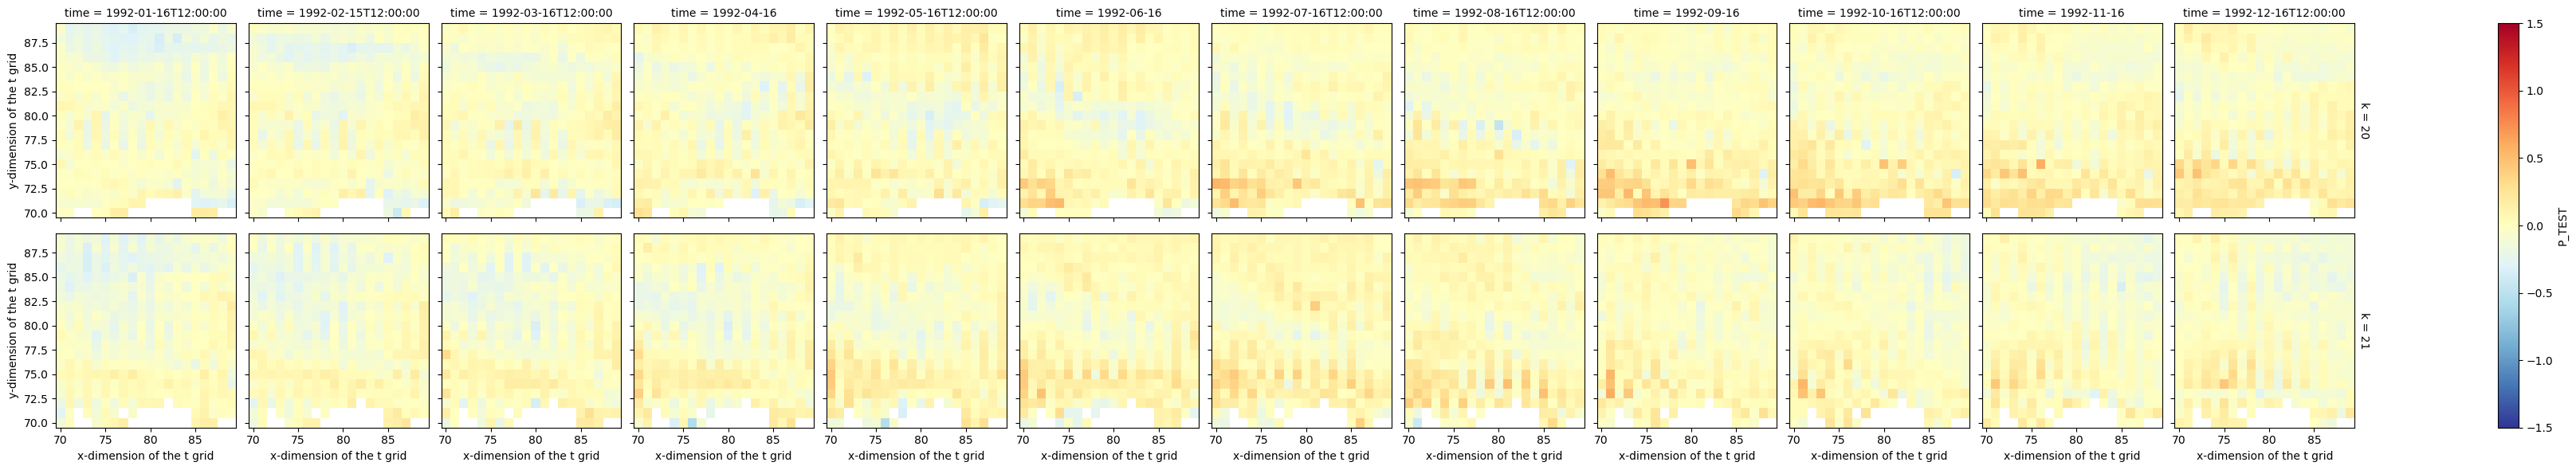

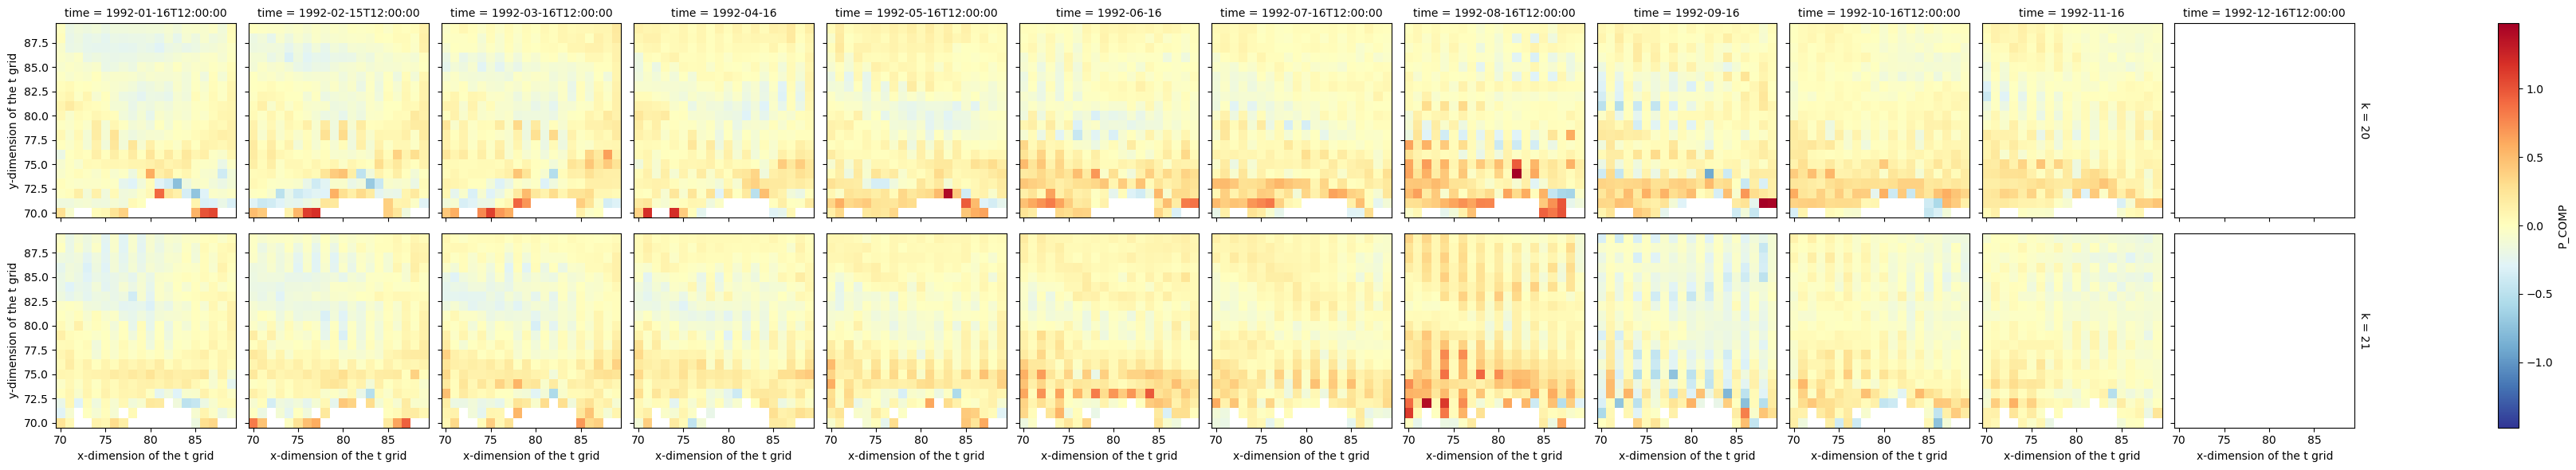

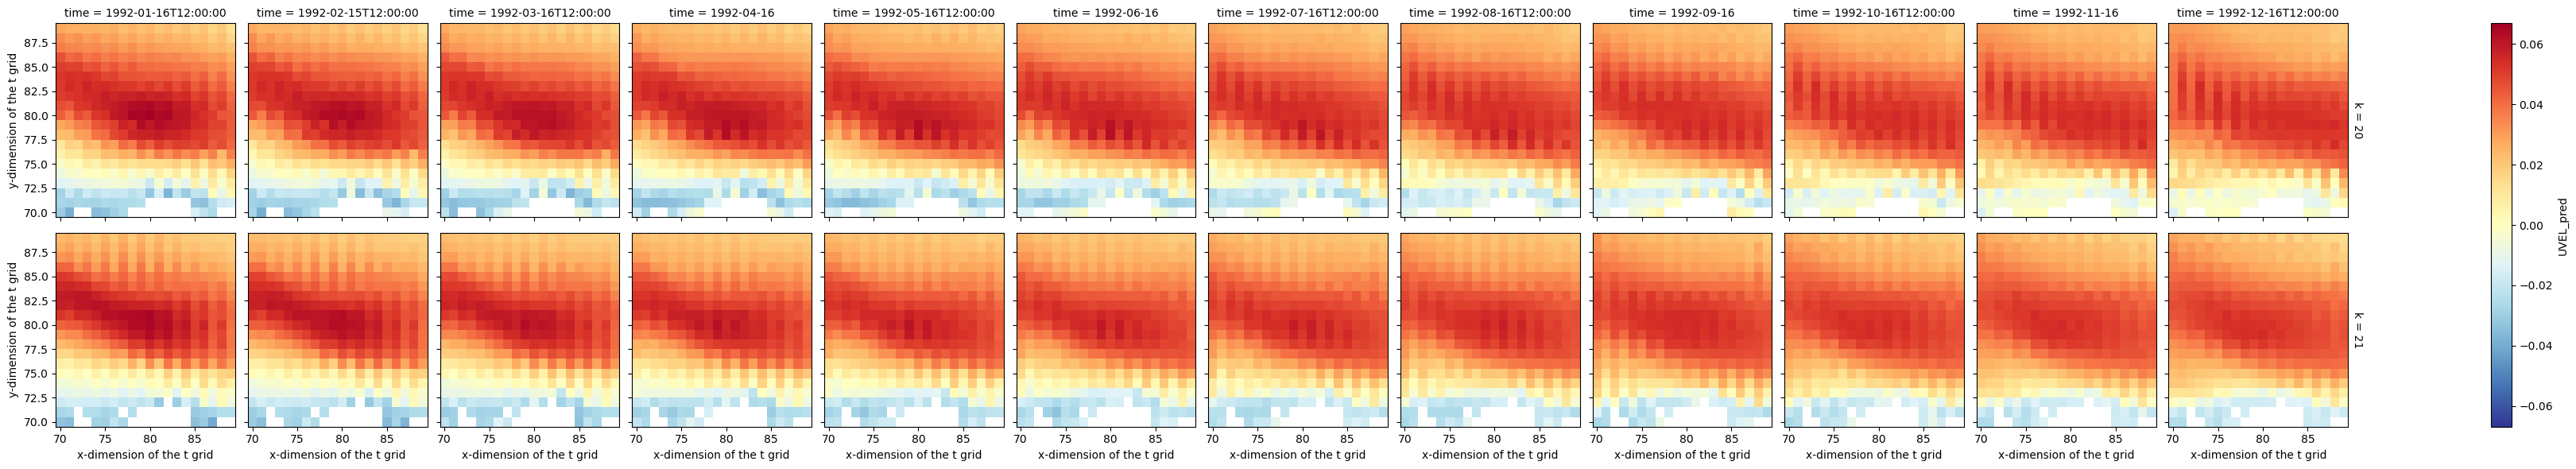

In [109]:
### WORKING GRADIENTS

# if __name__ == "__main__": 

#     all_grad, u_hat = model.compute_gradients(t_val, z_val, y_val, x_val, T_val, S_val, obp_val, ssh_val)

P_TEST = all_grad[0].reshape(new_size)
P_TEST = np.lib.pad(P_TEST, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(0))
ds_model['P_TEST'] = (('time','k','j', 'i'), P_TEST.squeeze())
ds_model = ds_model.reset_coords(['P_TEST']) # move from coordinate to variable

# YC_tiled = y_val.reshape(new_size)
# YC_tiled = np.lib.pad(YC_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))
# XC_tiled = x_val.reshape(new_size)
# XC_tiled = np.lib.pad(XC_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))
T_tiled = t_val.reshape(new_size)
T_tiled = np.lib.pad(T_tiled, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(np.nan))

P_COMP = u_pred.reshape(new_size)
P_COMP = np.lib.pad(P_COMP, ((size_offset[0],0),(0,size_offset[1]),(0,size_offset[2]),(0,size_offset[3])), 'constant', constant_values=(0))
ds_model['P_COMP'] = (('time','k','j', 'i'), P_COMP.squeeze())
ds_model['P_COMP'] = ds_model['P_COMP'].where(ds.maskC.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind))) # nan out land
P_COMP = np.ma.diff(ds_model['P_COMP'], axis=0).squeeze()/np.ma.diff(T_tiled, axis=0).squeeze()
P_COMP = np.lib.pad(P_COMP, ((0,1),(0,0),(0,0),(0,0)), 'constant', constant_values=(np.nan))
ds_model['P_COMP'] = (('time','k','j', 'i'), P_COMP.squeeze())
# ds_model = ds_model.reset_coords(['P_COMP'])

ds_model['P_TEST'].where(ds.maskC.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind))).isel(time=slice(0,12)).plot(x='i', y='j', row='k', col='time', cmap='RdYlBu_r',vmin=-1.5,vmax=1.5)
ds_model['P_COMP'].isel(time=slice(0,12)).plot(x='i', y='j', row='k', col='time', cmap='RdYlBu_r')
ds_model['UVEL_pred'].isel(time=slice(0,12)).plot(x='i', y='j', row='k', col='time', cmap='RdYlBu_r')

In [28]:
# analyzer = innvestigate.create_analyzer('deep_taylor',model)
# facet1err.size//20
# analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.BaselineLRPZ(model)


#"No analyzer with the name 'LRP-epsilon' could be found. All possible names are: ['input', 'random', 'gradient', 'gradient.baseline', 'input_t_gradient', 'deconvnet', 'guided_backprop', 'integrated_gradients', 'smoothgrad', 'lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat', 'lrp.sequential_preset_b_flat_until_idx', 'deep_taylor', 'deep_taylor.bounded', 'deep_lift.wrapper', 'pattern.net', 'pattern.attribution']"

536

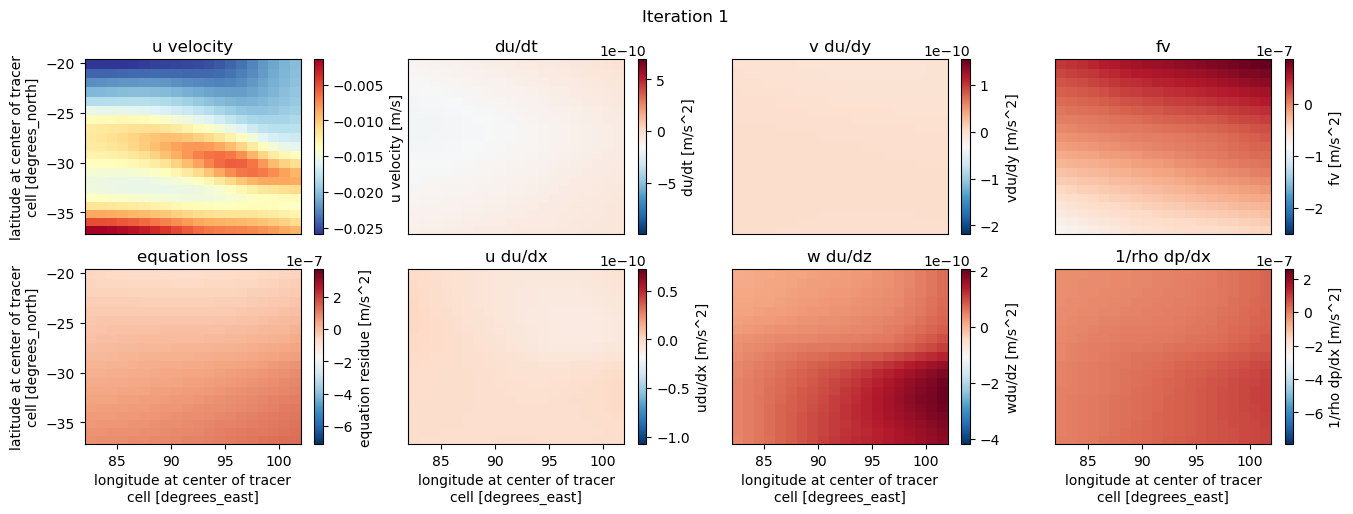

In [39]:
fig, ax = plt.subplots(2,4,figsize=(16,5))

# picture of the uvel
ds_model.UVEL_pred.isel(time=0,k=0).plot(x='XC',y='YC',cmap='RdYlBu_r',vmin=ds_model.UVEL_pred.isel(time=0,k=0).min(),vmax=ds_model.UVEL_pred.isel(time=0,k=0).max(),ax=ax[0,0],cbar_kwargs={'label': 'u velocity [m/s]'})
ax[0,0].set_xlabel('')
ax[0,0].set_xticks([])
ax[0,0].set_title('u velocity')

# equation residue map
eq_map = ds_model.EQ_RES.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.EQ_RES.isel(time=0,k=0).min(),vmax=ds_model.EQ_RES.isel(time=0,k=0).max(),ax=ax[1,0],cbar_kwargs={'label': 'equation residue [m/s^2]'})
ax[1,0].set_title('equation loss')

# mean equation residue scatter
# facet1err = ds_model.EQ_RES.isel(time=0,k=0).mean(['i','j'])
# ax[0,1].scatter(ds_model.iteration[0], facet1err[0], s = 10, color='blue')
# ax[0,1].set_xlabel('iterations')
# # ax[1].set_ylabel('equation residue')
# ax[0,1].set_xlim([0, facet1err.size])
# ax[0,1].set_ylim([ds_model.EQ_RES.isel(time=0,k=0).min(), ds_model.EQ_RES.isel(time=0,k=0).max()])

#
u_t_map = ds_model.U_T.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.U_T.isel(time=0,k=0).min(), vmax= ds_model.U_T.isel(time=0,k=0).max(), ax=ax[0,1],cbar_kwargs={'label': 'du/dt [m/s^2]'})
ax[0,1].set_xlabel('')
ax[0,1].set_xticks([])
ax[0,1].set_ylabel('')
ax[0,1].set_yticks([])
ax[0,1].set_title('du/dt')
uu_x_map = ds_model.UU_X.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.UU_X.isel(time=0,k=0).min(), vmax= ds_model.UU_X.isel(time=0,k=0).max(), ax=ax[1,1],cbar_kwargs={'label': 'udu/dx [m/s^2]'})
ax[1,1].set_ylabel('')
ax[1,1].set_yticks([])
ax[1,1].set_title('u du/dx')
vu_y_map = ds_model.VU_Y.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.VU_Y.isel(time=0,k=0).min(), vmax= ds_model.VU_Y.isel(time=0,k=0).max(), ax=ax[0,2],cbar_kwargs={'label': 'vdu/dy [m/s^2]'})
ax[0,2].set_xlabel('')
ax[0,2].set_xticks([])
ax[0,2].set_ylabel('')
ax[0,2].set_yticks([])
ax[0,2].set_title('v du/dy')
wu_z_map = ds_model.WU_Z.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.WU_Z.isel(time=0,k=0).min(), vmax= ds_model.WU_Z.isel(time=0,k=0).max(), ax=ax[1,2],cbar_kwargs={'label': 'wdu/dz [m/s^2]'})
ax[1,2].set_ylabel('')
ax[1,2].set_yticks([])
ax[1,2].set_title('w du/dz')
fv_map = ds_model.FV.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.FV.isel(time=0,k=0).min(), vmax= ds_model.FV.isel(time=0,k=0).max(), ax=ax[0,3],cbar_kwargs={'label': 'fv [m/s^2]'})
ax[0,3].set_title('fv')
ax[0,3].set_xlabel('')
ax[0,3].set_xticks([])
ax[0,3].set_ylabel('')
ax[0,3].set_yticks([])
p_x_map = ds_model.P_X.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.P_X.isel(time=0,k=0).min(), vmax= ds_model.P_X.isel(time=0,k=0).max(), ax=ax[1,3],cbar_kwargs={'label': '1/rho dp/dx [m/s^2]'})
ax[1,3].set_ylabel('')
ax[1,3].set_yticks([])
ax[1,3].set_title('1/rho dp/dx')

fig.suptitle('Iteration 1')

def animate(frame):
    # change the data for each of the panels
    eq_map.set_array(ds_model.EQ_RES.isel(time=0,k=0,iters=frame*10).values.flatten())
    u_t_map.set_array(ds_model.U_T.isel(time=0,k=0,iters=frame*10).values.flatten())
    uu_x_map.set_array(ds_model.UU_X.isel(time=0,k=0,iters=frame*10).values.flatten())
    vu_y_map.set_array(ds_model.VU_Y.isel(time=0,k=0,iters=frame*10).values.flatten())
    wu_z_map.set_array(ds_model.WU_Z.isel(time=0,k=0,iters=frame*10).values.flatten())
    fv_map.set_array(ds_model.FV.isel(time=0,k=0,iters=frame*10).values.flatten())
    p_x_map.set_array(ds_model.P_X.isel(time=0,k=0,iters=frame*10).values.flatten())
    
    # change iteration number
    fig.suptitle("Iteration "+str(frame*10+1))
#     ax[1].scatter(ds_model.iteration[frame*20], facet1err[frame*20], s = 10, color='blue')

ani = animation.FuncAnimation(fig, animate, ds_model.iteration.size//10) # len(eq_res)

ani.save('./images/all_terms.gif', writer='imagemagick', fps = 5) #Save animation as gif-file

# display afterwards so that it doesn't mess up the gif
# HTML(ani.to_jshtml()) #Show the animation in the kernel

In [40]:
HTML(ani.to_jshtml()) #Show the animation in the kernel

In [12]:
# # PUT THE VELOCITIES INTO A NEW XARRAY
# the Navier stokes components only work if the collocation points are also the validation points!!!!!!

subset_template = ds.THETA.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC)
T_pred = (T_pred+1)*char_train[4] + lb_train[4]
S_pred = (S_pred+1)*char_train[5] + lb_train[5]
UVEL_pred = (u_pred+1)*char_train[6] + lb_train[6]
VVEL_pred = (v_pred+1)*char_train[7] + lb_train[7]
WVELMASS_pred = (w_pred+1)*char_train[8] + lb_train[8]
P_pred = (p_pred+1)*char_train[9] + lb_train[9]
RHO_pred = (rho_pred+1)*char_train[10] + lb_train[10]

# reshaping back to 4d array
new_size = (np.unique(coords_val[:,0]).size,np.unique(coords_val[:,1]).size,np.unique(coords_val[:,2]).size,np.unique(coords_val[:,3]).size) # size of the original training domain

arrays_to_change = [UVEL_pred, VVEL_pred, WVELMASS_pred, P_pred, RHO_pred,T_pred, S_pred]#, Kx_pred, Ky_pred, Kz_pred] # no iteration data
for i in range(len(arrays_to_change)):
    arrays_to_change[i]= arrays_to_change[i].reshape(new_size)
    
# EQ_RES, U_T, UU_X, VU_Y, WU_Z, FV, P_X, U_PREDICTIONS = [np.zeros(new_size + (len(eq_res),)) for _ in range(8)] # add a new dimension for iterations
# for i in range(len(eq_res)):
#     # reshape each iteration of the model run to be the same shape as domain
#     EQ_RES[:,:,:,:,i] = eq_res[i].reshape(new_size)
#     U_T[:,:,:,:,i] = u_t[i].reshape(new_size)
#     UU_X[:,:,:,:,i] = uu_x[i].reshape(new_size)
#     VU_Y[:,:,:,:,i] = vu_y[i].reshape(new_size)
#     WU_Z[:,:,:,:,i] = wu_z[i].reshape(new_size)
#     FV[:,:,:,:,i] = fv[i].reshape(new_size)
#     P_X[:,:,:,:,i] = p_x[i].reshape(new_size)
#     U_PREDICTIONS[:,:,:,:,i] = u_predictions[i].reshape(new_size)

# U_PREDICTIONS = (U_PREDICTIONS+1)*char_train[8] + lb_train[8]
# arrays_to_change2 = [EQ_RES, U_T, UU_X, VU_Y, WU_Z, FV, P_X, U_PREDICTIONS]
    
# putting the predicted velocities into array to match the size of the model velocities
size_offset = np.array(subset_template.values.squeeze().shape) - np.array(arrays_to_change[0].shape)
# 'pad' the array with 0s to get it to be the same shape
# NOTE you have to change this if you mess with when the training data and testing data is

# these do not have iteration data
for i in range(len(arrays_to_change)):
    array_padding = ((size_offset[0], 0), (0, size_offset[1]), (0, size_offset[2]), (0, size_offset[3]))
    arrays_to_change[i] = np.lib.pad(arrays_to_change[i], array_padding, 'constant', constant_values=(np.nan))

# # these do have iteration data
# for i in range(len(arrays_to_change2)):
#     array_padding = ((size_offset[0], 0), (0, size_offset[1]), (0, size_offset[2]), (0, size_offset[3]), (0, 0))
#     arrays_to_change2[i] = np.lib.pad(arrays_to_change2[i], array_padding, 'constant', constant_values=(np.nan))

# ds_model is a new xarray that contains both predicted velocities and original velocities

tags = ['UVEL_pred', 'VVEL_pred', 'WVELMASS_pred', 'P_pred', 'RHO_pred','T_pred','S_pred']#,'Kx_pred','Ky_pred','Kz_pred']
# ds_model = xr.zeros_like(subset_template)
ds_model = subset_template
for i in range(len(tags)):
    ds_model[tags[i]] = (('time','k','j', 'i'), arrays_to_change[i])
    ds_model[tags[i]] = ds_model[tags[i]].where(ds.maskC.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)))

# ds_model = ds_model.expand_dims(dim={'iters': len(eq_res)}) # add new dimension for model iterations
# ds_model = ds_model.assign_coords(iteration=('iters', range(len(eq_res)))) # add corresponding new coordinate
# tags2 = ['EQ_RES', 'U_T', 'UU_X', 'VU_Y', 'WU_Z', 'FV', 'P_X', 'U_PREDICTIONS']
# for i in range(len(tags2)):
#     ds_model[tags2[i]] = (('time','k','j', 'i','iters'), arrays_to_change2[i])
#     ds_model[tags2[i]] = ds_model[tags2[i]].where(ds.maskC.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)))

ds_model = xr.merge([ds_model, ds.SALT.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)), ds.EVEL.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).NVEL.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).WVELMASS_interp.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).PHI.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)), ds.RHOAnoma.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind))],compat='override')
ds_model = ds_model.reset_coords(tags) # move from coordinate to variable
# ds_model = ds_model.reset_coords(tags2) # move from coordinate to variable

# # set the differences into the output dataset 
ds_model['THETA_diff'] = ds_model.THETA - ds_model.T_pred
ds_model['SALT_diff'] = ds_model.SALT - ds_model.S_pred
ds_model['UVEL_diff'] = ds_model.EVEL - ds_model.UVEL_pred
ds_model['VVEL_diff'] = ds_model.NVEL - ds_model.VVEL_pred 
ds_model['WVELMASS_diff'] = ds_model.WVELMASS_interp - ds_model.WVELMASS_pred 
ds_model['P_diff'] = ds_model.PHI - ds_model.P_pred
ds_model['RHO_diff'] = ds_model.RHOAnoma - ds_model.RHO_pred 
# ds_model['Kz_diff'] = ds_model.DIFFKR - ds_model.Kz_pred
ds_model['THETA_snr'] = ds_model.THETA.std(dim='time').load()/ds_model.THETA_diff.std(dim='time').load()
ds_model['SALT_snr'] = ds_model.SALT.std(dim='time').load()/ds_model.SALT_diff.std(dim='time').load()
ds_model['UVEL_snr'] = ds_model.EVEL.std(dim='time').load()/ds_model.UVEL_diff.std(dim='time').load()
ds_model['VVEL_snr'] = ds_model.NVEL.std(dim='time').load()/ds_model.VVEL_diff.std(dim='time').load()
ds_model['WVELMASS_snr'] = ds_model.WVELMASS_interp.std(dim='time').load()/ds_model.WVELMASS_diff.std(dim='time').load()
ds_model['P_snr'] = ds_model.PHI.std(dim='time').load()/ds_model.P_diff.std(dim='time').load()
ds_model['RHO_snr'] = ds_model.RHOAnoma.std(dim='time').load()/ds_model.RHO_diff.std(dim='time').load()

print('done with this section!')

done with this section!


In [13]:
### PLOTTING FUNCTIONS
def make_a_quiver(inputs_val, char_val, lb_val, inputs_train, char_train, lb_train, u_pred, v_pred, w_pred):
    fig, axs = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': '3d'})
    
    ### QUIVER PLOT - TRAINING DATA

    # Color by magnitude of velocity
    
    UVEL_pred = (inputs_val[:,8:9]+1)*char_val[8] + lb_val[8]
    VVEL_pred = (inputs_val[:,9:10]+1)*char_val[9] + lb_val[9]
    WVELMASS_pred = (inputs_val[:,10:11]+1)*char_val[10] + lb_val[10]
    x_val = ((inputs_val[:,3:4]+1)*char_val[3] + lb_val[3])/111.32/1000
    y_val = ((inputs_val[:,2:3]+1)*char_val[2] + lb_val[2])/111.32/1000
    z_val = ((inputs_val[:,1:2]+1)*char_val[1] + lb_val[1])

    c = np.sqrt(UVEL_pred**2 + VVEL_pred**2 + WVELMASS_pred**2) # find magnitude of velocity
    c = (c.ravel() - c.min()) / c.ptp() # flatten and normalize
    c = np.concatenate((c, np.repeat(c, 2))) # repeat for each body line and two head lines
    c = plt.cm.RdYlBu_r(c) # colormap

    axs[0].quiver(x_val, y_val, z_val, UVEL_pred, VVEL_pred, WVELMASS_pred, length=0.3, normalize=True, colors=c, cmap='RdYlBu_r', alpha=0.4)
    # Set labels and zticks
    axs[0].set(xlabel='longitude', ylabel='latitude', zlabel='depth')
    axs[0].set_title("True velocities")

    ### QUIVER PLOT - PREDICTION

    # Color by magnitude of velocity
    UVEL_pred = (u_pred+1)*char_train[8] + lb_train[8]
    VVEL_pred = (v_pred+1)*char_train[9] + lb_train[9]
    WVELMASS_pred = (w_pred+1)*char_train[10] + lb_train[10]

    c = np.sqrt(UVEL_pred**2 + VVEL_pred**2 + WVELMASS_pred*2) # find magnitude of velocity
    c = (c.ravel() - c.min()) / c.ptp() # flatten and normalize
    c = np.concatenate((c, np.repeat(c, 2))) # repeat for each body line and two head lines
    c = plt.cm.RdYlBu_r(c) # colormap

    quivers = axs[1].quiver(x_val, y_val, z_val, UVEL_pred, VVEL_pred, WVELMASS_pred, length=0.3, normalize=True, colors=c, cmap='RdYlBu_r', alpha=0.4)
    # Set labels and zticks
    axs[1].set(xlabel='longitude', ylabel='latitude', zlabel='depth')
    axs[0].set_title("Predicted velocities")
    fig.colorbar(quivers, ax=axs.ravel().tolist())
    fig.tight_layout()
    plt.show()
    

def make_a_cube(ds_model, output_type):
    # plot a 3d cube plot of the prediction or training data
    # output type ranges from 0 to 4 for EVEL (0), NVEL (1), WVEL (2), PHIHYD (3), or RHO (4)
    # t_or_p can be training (0) or prediction (1)
    # ex: make_a_cube(ds_model, 3, 0)

    tags = [['THETA','SALT','EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma','DIFFKR'],
            ['T_pred','S_pred','UVEL_pred','VVEL_pred','WVELMASS_pred','P_pred','RHO_pred','Kz_pred'],
           ['THETA_diff','SALT_diff','UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff','Kz_diff']]

    levels=np.linspace(min(ds_model[tags[0][output_type]].min(),ds_model[tags[1][output_type]].min()).values, max(ds_model[tags[0][output_type]].max(),ds_model[tags[1][output_type]].max()), 20)

    seismic_nanmasked = plt.get_cmap('RdYlBu_r').copy()
    seismic_nanmasked.set_bad('white')

    # Create a figure with 3D ax
    fig, axs = plt.subplots(1, 3, figsize=(24,8), subplot_kw={'projection': '3d'})

    # #Set limits of the plot from coord limits
    xmin, xmax = ds_model.longitude.min(), ds_model.longitude.max()
    ymin, ymax = ds_model.latitude.min(), ds_model.latitude.max()
    zmin, zmax = ds.Z.isel(k=k_ind[1]), ds.Z.isel(k=k_ind[0])
    for ax in axs:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
        # Plot edges
        edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
        ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
        ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
        ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        # Set labels and zticks
        ax.set(xlabel='longitude', ylabel='latitude', zlabel='depth')

    # TRAINING DATA
    if output_type < 7:
        # XY plot
        axs[0].contourf(ds_model.longitude.values, ds_model.latitude.values, ds_model[tags[0][output_type]].isel(k=0,time=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

        ## XZ plot
        axs[0].contourf(np.tile(ds_model.longitude,(k_ind[1]-k_ind[0],1)), ds_model[tags[0][output_type]].isel(j=0,time=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

        ## YZ plot
        axs[0].contourf(ds_model[tags[0][output_type]].isel(i=-1,time=0).values, np.tile(ds_model.latitude,(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

    elif output_type == 7:
        
        levels=np.linspace(ds_model[tags[0][output_type]].min(), ds_model[tags[0][output_type]].max(), 20)
        
        # XY plot
        axs[0].contourf(ds_model.XC.isel(tile=0).values, ds_model.YC.isel(tile=0).values, ds_model[tags[0][output_type]].isel(k=0, tile=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

        ## XZ plot
        axs[0].contourf(np.tile(ds_model.XC.isel(j=0,tile=0),(k_ind[1]-k_ind[0],1)), ds_model[tags[0][output_type]].isel(j=0,tile=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

        ## YZ plot
        axs[0].contourf(ds_model[tags[0][output_type]].isel(i=-1,tile=0).values, np.tile(ds_model.YC.isel(i=-1,tile=0),(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

        levels=np.linspace(min(ds_model[tags[0][output_type]].min(),ds_model[tags[1][output_type]].min()).values, max(ds_model[tags[0][output_type]].max(),ds_model[tags[1][output_type]].max()), 20)
        
    # PREDICTION DATA
    # XY plot
    axs[1].contourf(ds_model.longitude.values, ds_model.latitude.values, ds_model[tags[1][output_type]].isel(k=0,time=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

    ## XZ plot
    axs[1].contourf(np.tile(ds_model.longitude,(k_ind[1]-k_ind[0],1)), ds_model[tags[1][output_type]].isel(j=0,time=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

    ## YZ plot
    C = axs[1].contourf(ds_model[tags[1][output_type]].isel(i=-1,time=0).values, np.tile(ds_model.latitude,(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

    # DIFFERENCE DATA

    levels=np.linspace(ds_model[tags[2][output_type]].min().values, ds_model[tags[2][output_type]].max(), 20)
    seismic_nanmasked = plt.get_cmap('RdBu_r').copy()
    # norm = colors.TwoSlopeNorm(vmin=ds_model[tags[2][output_type]].min().values, vcenter=0, vmax=ds_model[tags[2][output_type]].max())
    seismic_nanmasked.set_bad('white')

    # XY plot
    axs[2].contourf(ds_model.longitude.values, ds_model.latitude.values, ds_model[tags[2][output_type]].isel(k=0,time=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

    ## XZ plot
    axs[2].contourf(np.tile(ds_model.longitude,(k_ind[1]-k_ind[0],1)), ds_model[tags[2][output_type]].isel(j=0,time=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

    ## YZ plot
    D = axs[2].contourf(ds_model[tags[2][output_type]].isel(i=-1,time=0).values, np.tile(ds_model.latitude,(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

#     # Colorbar
    cbar = fig.colorbar(C, ax=axs[0:2], pad=0.1, label=tags[0][output_type],fraction=0.018)#, orientation='horizontal')
    fig.colorbar(D, ax=axs[2],pad=0.1, label=tags[2][output_type],fraction=0.04)

    axs[0].set_title("True "+tags[0][output_type])
    axs[1].set_title("Predicted "+tags[0][output_type])
    axs[2].set_title("True - predicted "+tags[0][output_type])

    # Show Figure
    # fig.tight_layout()
    plt.show()

In [40]:
# ### TESTING THE PLOTTING FUNCTIONS
# # make_a_quiver(inputs_val, char_val, lb_val, inputs_train, char_train, lb_train, u_pred, v_pred, w_pred)
# make_a_cube(ds_model, 6)

# std in space instead of time for the snr 
# # ds_model

array([[[0.01364756, 0.01232964, 0.01159844, ..., 0.01558635,
         0.01689449, 0.01829912],
        [0.01425998, 0.01301229, 0.01205606, ..., 0.01549279,
         0.01685018, 0.01850836],
        [0.0118923 , 0.01146092, 0.01090569, ..., 0.01457062,
         0.01619749, 0.01847921],
        ...,
        [0.01249144, 0.01305942, 0.01352786, ..., 0.01498248,
         0.01567448, 0.01564369],
        [0.01129759, 0.01233409, 0.01310852, ..., 0.01478346,
         0.01528255, 0.0153772 ],
        [0.01079608, 0.01237722, 0.01337736, ..., 0.01427032,
         0.01442686, 0.01458082]],

       [[0.01408766, 0.01278195, 0.01187143, ..., 0.01449995,
         0.01608711, 0.01734764],
        [0.01449754, 0.01293076, 0.01178798, ..., 0.01356872,
         0.01541364, 0.01707488],
        [0.01225836, 0.01127394, 0.01027243, ..., 0.0130939 ,
         0.01480994, 0.01704578],
        ...,
        [0.01130412, 0.01197127, 0.01265298, ..., 0.01390937,
         0.01442401, 0.01453662],
        [0.0

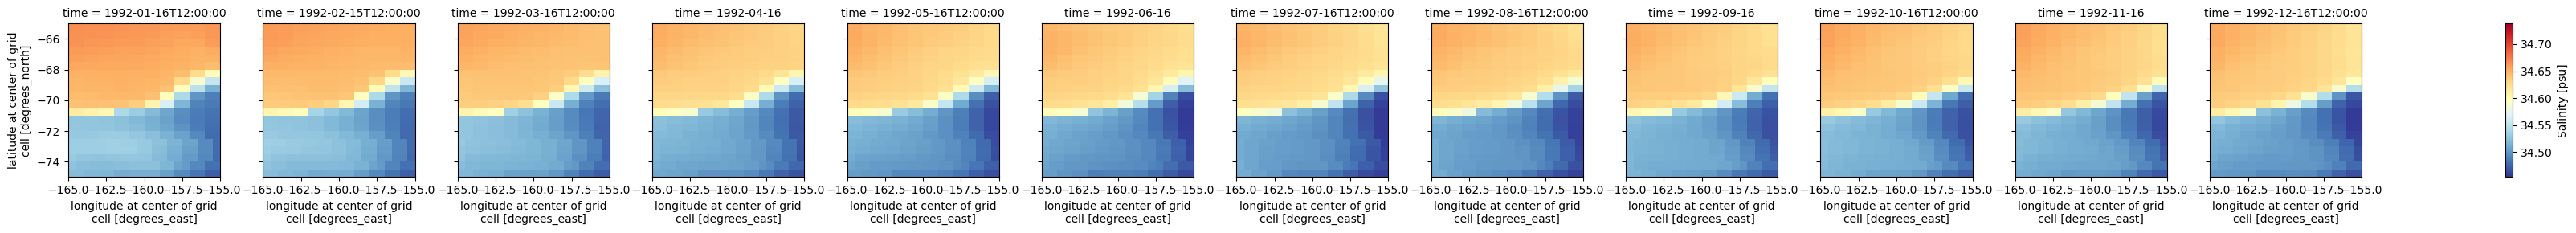

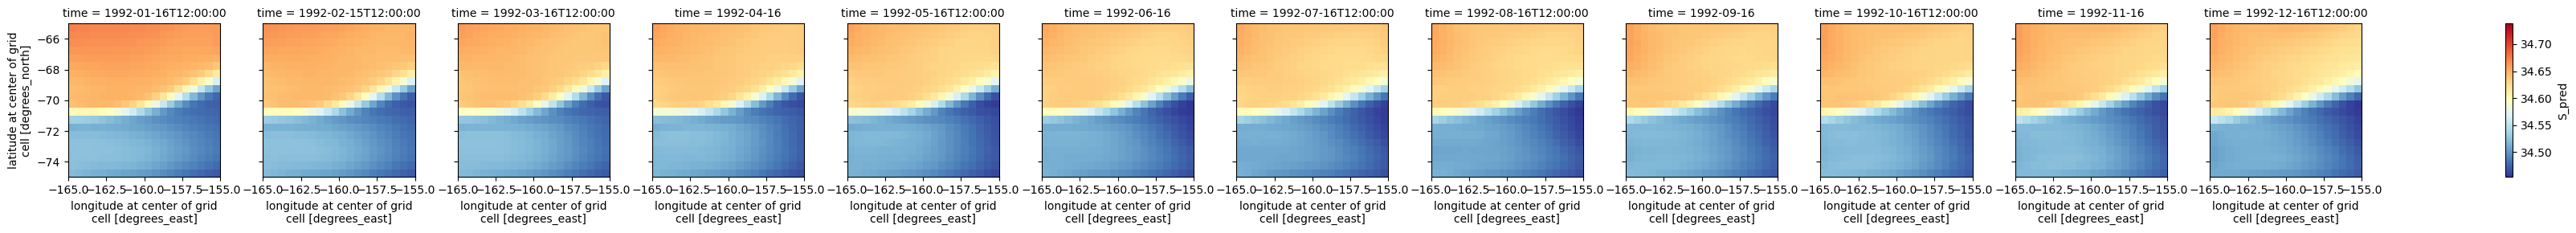

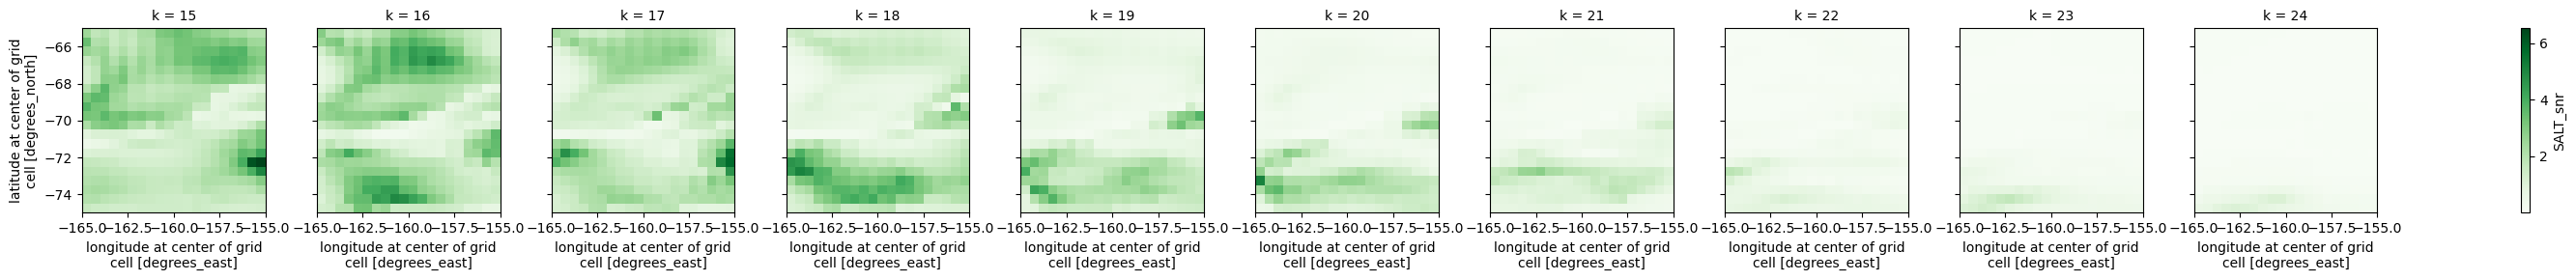

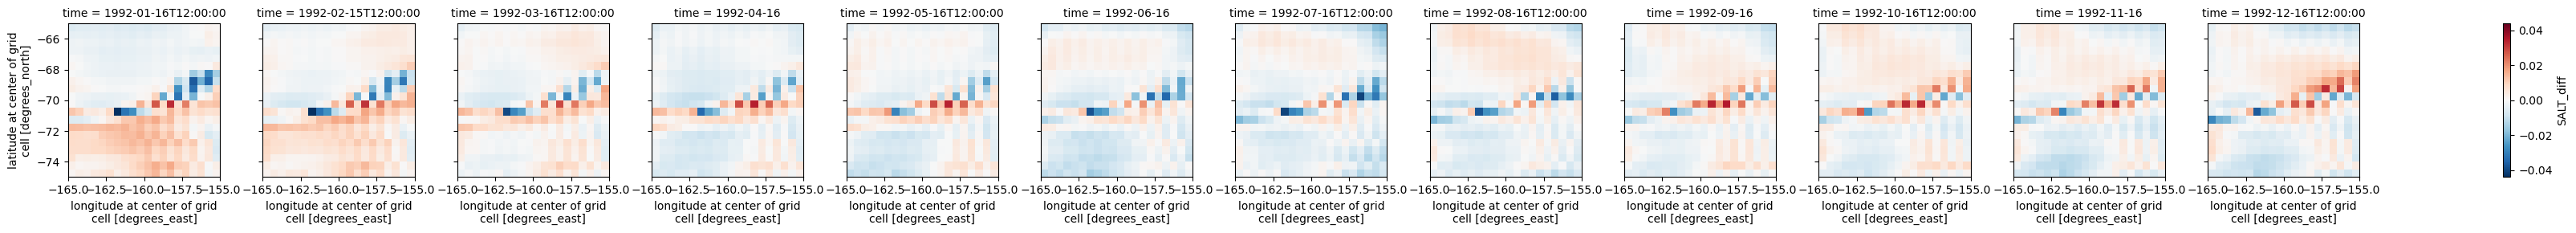

In [47]:
# make a mega plot of 4d data of zonal velocity

tags = [['THETA','SALT','EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma'],
        ['T_pred','S_pred','UVEL_pred','VVEL_pred','WVELMASS_pred','P_pred','RHO_pred'],
        ['THETA_diff','SALT_diff','UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff'],
       ['THETA_snr','SALT_snr','UVEL_snr','VVEL_snr','WVELMASS_snr','P_snr','RHO_snr']]

output_type = 1
tag_true = tags[0][output_type]
tag_pred = tags[1][output_type]
tag_diff = tags[2][output_type]
tag_snr = tags[3][output_type]

chosen_depth=15
# # # each row of plots is a depth, each column is a time
vmin = min(ds_model[tag_true].min(),ds_model[tag_pred].min()).values
vmax = max(ds_model[tag_true].max(),ds_model[tag_pred].max()).values
ds_model[tag_true].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='longitude', y='latitude', col='time', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_pred].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='longitude', y='latitude', col='time', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_snr].plot(x='longitude', y='latitude', col='k',cmap='Greens')
ds_model[tag_diff].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='longitude', y='latitude', col='time')
plt.show()


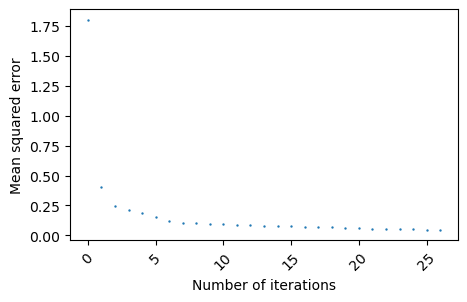

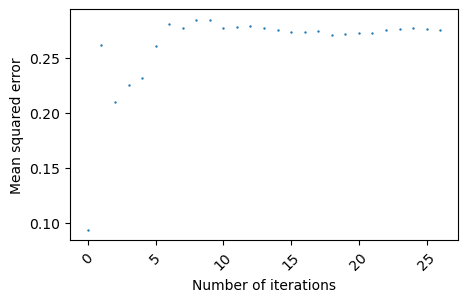

In [48]:
######## Losses after each iteration #######################
########           ########### 
fig, ax = plt.subplots(1, 1, figsize=(5,3))
iterations = list(range(0,len(data_losses)))
ax.scatter(iterations, data_losses, s = 0.5)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Mean squared error')
plt.xticks(rotation=45);

fig, ax = plt.subplots(1, 1, figsize=(5,3))
# iterations = list(range(0,nIter,10))
iterations = list(range(0,len(eq_losses)))
ax.scatter(iterations, eq_losses, s = 0.5)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Mean squared error')
# ax.set_ylim([0,1])
plt.xticks(rotation=45);

#ax.set_aspect('equal', 'box')